In [1]:
# Install required packages

!pip install efficientnet-pytorch
!pip install pytorch-quantization
!pip install tensorrt
!pip install onnx
!pip install timm

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.quantization import QConfig, default_qconfig
from torch.quantization.quantize_fx import prepare_qat_fx, convert_fx
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'efficientnet-pytorch' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'efficientnet-pytorch'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16477 sha256=e58ad62d66f434a4faafd1c929a4b45368eebd92b8dd3a058097b9bc8545e34c
  Stored in directory: /home/mukul/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ ex

In [4]:
import math

class FP4Quantizer:
    """
    FP4 E2M1 format quantization implementation
    Based on the format described in the research papers
    """
    def __init__(self, format_type='E2M1'):
        self.format_type = format_type
        # FP4 E2M1 quantization levels (16 values)
        self.fp4_values = torch.tensor([
            -6.0, -4.0, -3.0, -2.0, -1.5, -1.0, -0.5, 0.0,
            0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 0.0  # 16 values
        ], dtype=torch.float32)
    
    def quantize(self, x, scale_factor=None):
        """
        Quantize tensor to FP4 format using absmax scaling
        """
        if scale_factor is None:
            # Calculate absmax scale factor
            max_val = torch.max(torch.abs(x))
            scale_factor = 6.0 / max_val  # 6.0 is MAX_FP4 for E2M1
        
        # Scale input
        x_scaled = x * scale_factor
        
        # Clamp to FP4 range
        x_clamped = torch.clamp(x_scaled, -6.0, 6.0)
        
        # Quantize using lookup table
        quantized = self._quantize_lookup(x_clamped)
        
        return quantized / scale_factor, scale_factor
    
    def _quantize_lookup(self, x):
        """
        Quantize using lookup table for FP4 values
        """
        # Find closest FP4 value for each element
        x_flat = x.flatten()
        quantized_flat = torch.zeros_like(x_flat)
        
        for i, val in enumerate(x_flat):
            diff = torch.abs(self.fp4_values - val)
            closest_idx = torch.argmin(diff)
            quantized_flat[i] = self.fp4_values[closest_idx]
        
        return quantized_flat.reshape(x.shape)

class OutlierClampingCompensation:
    """
    Outlier Clamping and Compensation for activations
    Based on recent FP4 training research
    """
    def __init__(self, quantile=0.99):
        self.quantile = quantile
    
    def apply(self, x):
        """
        Apply outlier clamping and return clamped tensor and compensation matrix
        """
        # Calculate quantile thresholds
        threshold = torch.quantile(torch.abs(x), self.quantile)
        
        # Clamp outliers
        x_clamped = torch.clamp(x, -threshold, threshold)
        
        # Calculate compensation matrix (sparse)
        compensation = x - x_clamped
        
        return x_clamped, compensation


In [5]:
class QuantizedConv2d(nn.Module):
    """
    Custom quantized convolution with FP4 support
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.weight_quantizer = FP4Quantizer()
        self.activation_quantizer = FP4Quantizer()
        self.outlier_handler = OutlierClampingCompensation()
        
    def forward(self, x):
        # Quantize weights
        weight_q, weight_scale = self.weight_quantizer.quantize(self.conv.weight)
        
        # Handle activation outliers
        x_clamped, compensation = self.outlier_handler.apply(x)
        
        # Quantize activations
        x_q, act_scale = self.activation_quantizer.quantize(x_clamped)
        
        # Perform convolution with quantized weights and activations
        # Note: This is a simulation - actual hardware would handle this differently
        output = F.conv2d(x_q, weight_q, self.conv.bias, 
                         self.conv.stride, self.conv.padding)
        
        # Add compensation for outliers (sparse matrix multiplication)
        if torch.sum(torch.abs(compensation)) > 0:
            comp_output = F.conv2d(compensation, self.conv.weight, None,
                                 self.conv.stride, self.conv.padding)
            output += comp_output
        
        return output

class QuantizedEfficientNet(nn.Module):
    """
    EfficientNet with FP4 quantization
    """
    def __init__(self, model_name='efficientnet-b0', num_classes=1000):
        super().__init__()
        # Load pre-trained EfficientNet
        self.backbone = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
        
        # Replace key layers with quantized versions
        self._replace_layers()
        
    def _replace_layers(self):
        """
        Replace standard layers with quantized versions
        """
        # This is a simplified replacement - in practice, you'd need to handle
        # all conv layers in the MBConv blocks
        for name, module in self.backbone.named_modules():
            if isinstance(module, nn.Conv2d) and 'features' in name:
                # Replace with quantized conv
                new_conv = QuantizedConv2d(
                    module.in_channels, 
                    module.out_channels, 
                    module.kernel_size, 
                    module.stride, 
                    module.padding
                )
                # Copy weights
                new_conv.conv.weight.data = module.weight.data.clone()
                if module.bias is not None:
                    new_conv.conv.bias.data = module.bias.data.clone()
                
                # Replace in model
                parent_name = '.'.join(name.split('.')[:-1])
                child_name = name.split('.')[-1]
                parent = self.backbone
                for part in parent_name.split('.'):
                    if part:
                        parent = getattr(parent, part)
                setattr(parent, child_name, new_conv)
    
    def forward(self, x):
        return self.backbone(x)


In [6]:
class FP4QATTrainer:
    """
    Quantization-Aware Training trainer for FP4 EfficientNet
    """
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Setup optimizer with lower learning rate for QAT
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-5, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        self.criterion = nn.CrossEntropyLoss()
        
    def train_epoch(self):
        """
        Train for one epoch
        """
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(self.train_loader, desc="Training")):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        return total_loss / len(self.train_loader), 100. * correct / total
    
    def validate(self):
        """
        Validate the model
        """
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in tqdm(self.val_loader, desc="Validation"):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                val_loss += self.criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        
        return val_loss / len(self.val_loader), 100. * correct / total
    
    def train(self, epochs=50):
        """
        Full training loop
        """
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        
        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            
            # Training
            train_loss, train_acc = self.train_epoch()
            
            # Validation
            val_loss, val_acc = self.validate()
            
            # Update scheduler
            self.scheduler.step()
            
            # Store metrics
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
            # Save best model
            if epoch == 0 or val_acc > max(val_accs[:-1]):
                torch.save(self.model.state_dict(), 'best_fp4_efficientnet.pth')
                print('Best model saved!')
        
        return {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs
        }


In [7]:
def prepare_data(batch_size=32):
    """
    Prepare CIFAR-10 dataset for training
    """
    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation transform
    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    from torchvision.datasets import CIFAR10
    
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = CIFAR10(root='./data', train=False, download=True, transform=val_transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           shuffle=False, num_workers=4)
    
    return train_loader, val_loader


Starting FP4 EfficientNet Quantization-Aware Training
Preparing data...
Creating quantized EfficientNet model...
Loaded pretrained weights for efficientnet-b0
Starting training...

Epoch 1/50


Training:   0%|                                | 2/1563 [00:00<09:42,  2.68it/s]

Batch 0, Loss: 2.301428


Training:   6%|█▉                            | 101/1563 [00:10<02:16, 10.74it/s]

Batch 100, Loss: 2.211403


Training:  13%|███▉                          | 203/1563 [00:20<02:02, 11.10it/s]

Batch 200, Loss: 2.140699


Training:  19%|█████▊                        | 303/1563 [00:30<02:05, 10.08it/s]

Batch 300, Loss: 2.030326


Training:  26%|███████▋                      | 402/1563 [00:40<02:01,  9.53it/s]

Batch 400, Loss: 1.962276


Training:  32%|█████████▌                    | 501/1563 [00:50<01:44, 10.19it/s]

Batch 500, Loss: 1.788283


Training:  39%|███████████▌                  | 603/1563 [01:01<01:34, 10.19it/s]

Batch 600, Loss: 1.525963


Training:  45%|█████████████▍                | 702/1563 [01:10<01:21, 10.55it/s]

Batch 700, Loss: 1.457282


Training:  51%|███████████████▍              | 802/1563 [01:19<01:19,  9.57it/s]

Batch 800, Loss: 1.274571


Training:  58%|█████████████████▎            | 902/1563 [01:29<01:06,  9.94it/s]

Batch 900, Loss: 1.010885


Training:  64%|██████████████████▌          | 1002/1563 [01:38<00:52, 10.62it/s]

Batch 1000, Loss: 0.918424


Training:  71%|████████████████████▍        | 1103/1563 [01:48<00:46,  9.93it/s]

Batch 1100, Loss: 0.951643


Training:  77%|██████████████████████▎      | 1202/1563 [01:58<00:32, 10.96it/s]

Batch 1200, Loss: 0.749010


Training:  83%|████████████████████████▏    | 1303/1563 [02:07<00:23, 11.02it/s]

Batch 1300, Loss: 0.814501


Training:  90%|██████████████████████████   | 1402/1563 [02:17<00:17,  9.40it/s]

Batch 1400, Loss: 0.772378


Training:  96%|███████████████████████████▊ | 1502/1563 [02:27<00:06,  9.81it/s]

Batch 1500, Loss: 0.784802


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.41it/s]


Train Loss: 1.4249, Train Acc: 60.99%
Val Loss: 0.6699, Val Acc: 85.22%
Best model saved!

Epoch 2/50


Training:   0%|                                | 2/1563 [00:00<07:14,  3.59it/s]

Batch 0, Loss: 0.765654


Training:   7%|█▉                            | 102/1563 [00:10<02:29,  9.80it/s]

Batch 100, Loss: 0.586531


Training:  13%|███▉                          | 203/1563 [00:20<02:11, 10.35it/s]

Batch 200, Loss: 0.509439


Training:  19%|█████▊                        | 302/1563 [00:30<02:07,  9.87it/s]

Batch 300, Loss: 0.625270


Training:  26%|███████▋                      | 402/1563 [00:40<02:03,  9.39it/s]

Batch 400, Loss: 0.626387


Training:  32%|█████████▋                    | 502/1563 [00:51<01:42, 10.35it/s]

Batch 500, Loss: 0.507093


Training:  39%|███████████▌                  | 602/1563 [01:01<01:39,  9.70it/s]

Batch 600, Loss: 0.686991


Training:  45%|█████████████▍                | 702/1563 [01:11<01:29,  9.63it/s]

Batch 700, Loss: 0.557694


Training:  51%|███████████████▍              | 803/1563 [01:21<01:14, 10.18it/s]

Batch 800, Loss: 0.595885


Training:  58%|█████████████████▎            | 902/1563 [01:32<01:08,  9.72it/s]

Batch 900, Loss: 0.723617


Training:  64%|██████████████████▌          | 1002/1563 [01:42<00:58,  9.57it/s]

Batch 1000, Loss: 0.554612


Training:  71%|████████████████████▍        | 1102/1563 [01:52<00:49,  9.22it/s]

Batch 1100, Loss: 0.392673


Training:  77%|██████████████████████▎      | 1202/1563 [02:03<00:40,  9.02it/s]

Batch 1200, Loss: 0.530781


Training:  83%|████████████████████████▏    | 1302/1563 [02:13<00:26,  9.67it/s]

Batch 1300, Loss: 0.298940


Training:  90%|██████████████████████████   | 1402/1563 [02:24<00:16,  9.78it/s]

Batch 1400, Loss: 0.485128


Training:  96%|███████████████████████████▊ | 1502/1563 [02:34<00:06,  9.45it/s]

Batch 1500, Loss: 0.426163


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.61it/s]


Train Loss: 0.5408, Train Acc: 83.57%
Val Loss: 0.3285, Val Acc: 91.03%
Best model saved!

Epoch 3/50


Training:   0%|                                | 2/1563 [00:00<07:14,  3.59it/s]

Batch 0, Loss: 0.605205


Training:   7%|█▉                            | 102/1563 [00:10<02:29,  9.75it/s]

Batch 100, Loss: 0.417726


Training:  13%|███▉                          | 202/1563 [00:20<02:05, 10.85it/s]

Batch 200, Loss: 0.190130


Training:  19%|█████▊                        | 303/1563 [00:30<01:54, 11.04it/s]

Batch 300, Loss: 0.289808


Training:  26%|███████▋                      | 402/1563 [00:40<02:00,  9.62it/s]

Batch 400, Loss: 0.427102


Training:  32%|█████████▋                    | 503/1563 [00:50<01:37, 10.83it/s]

Batch 500, Loss: 0.619084


Training:  39%|███████████▌                  | 602/1563 [00:59<01:40,  9.54it/s]

Batch 600, Loss: 0.369047


Training:  45%|█████████████▍                | 702/1563 [01:10<01:30,  9.55it/s]

Batch 700, Loss: 0.503687


Training:  51%|███████████████▍              | 803/1563 [01:20<01:11, 10.59it/s]

Batch 800, Loss: 0.361906


Training:  58%|█████████████████▎            | 903/1563 [01:30<01:01, 10.71it/s]

Batch 900, Loss: 0.479670


Training:  64%|██████████████████▌          | 1002/1563 [01:40<00:58,  9.58it/s]

Batch 1000, Loss: 0.413562


Training:  71%|████████████████████▍        | 1102/1563 [01:50<00:48,  9.57it/s]

Batch 1100, Loss: 0.632496


Training:  77%|██████████████████████▎      | 1202/1563 [02:00<00:36,  9.91it/s]

Batch 1200, Loss: 0.509634


Training:  83%|████████████████████████▏    | 1302/1563 [02:10<00:26,  9.94it/s]

Batch 1300, Loss: 0.396346


Training:  90%|██████████████████████████   | 1402/1563 [02:20<00:14, 10.91it/s]

Batch 1400, Loss: 0.401635


Training:  96%|███████████████████████████▉ | 1503/1563 [02:30<00:05, 10.78it/s]

Batch 1500, Loss: 0.295301


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.03it/s]


Train Loss: 0.3900, Train Acc: 87.36%
Val Loss: 0.2381, Val Acc: 92.77%
Best model saved!

Epoch 4/50


Training:   0%|                                | 2/1563 [00:00<07:01,  3.70it/s]

Batch 0, Loss: 0.161258


Training:   6%|█▉                            | 101/1563 [00:10<02:22, 10.25it/s]

Batch 100, Loss: 0.309440


Training:  13%|███▉                          | 202/1563 [00:20<02:16,  9.94it/s]

Batch 200, Loss: 0.340675


Training:  19%|█████▊                        | 303/1563 [00:30<02:06,  9.94it/s]

Batch 300, Loss: 0.514511


Training:  26%|███████▋                      | 402/1563 [00:40<01:55, 10.05it/s]

Batch 400, Loss: 0.215560


Training:  32%|█████████▋                    | 502/1563 [00:50<01:45, 10.03it/s]

Batch 500, Loss: 0.160307


Training:  39%|███████████▌                  | 602/1563 [01:01<01:37,  9.84it/s]

Batch 600, Loss: 0.485953


Training:  45%|█████████████▍                | 702/1563 [01:10<01:15, 11.34it/s]

Batch 700, Loss: 0.267698


Training:  51%|███████████████▍              | 802/1563 [01:20<01:18,  9.64it/s]

Batch 800, Loss: 0.294729


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:09,  9.54it/s]

Batch 900, Loss: 0.306113


Training:  64%|██████████████████▌          | 1002/1563 [01:41<00:55, 10.16it/s]

Batch 1000, Loss: 0.281711


Training:  71%|████████████████████▍        | 1102/1563 [01:51<00:47,  9.69it/s]

Batch 1100, Loss: 0.176703


Training:  77%|██████████████████████▎      | 1201/1563 [02:01<00:35, 10.10it/s]

Batch 1200, Loss: 0.378227


Training:  83%|████████████████████████▏    | 1303/1563 [02:11<00:24, 10.63it/s]

Batch 1300, Loss: 0.137545


Training:  90%|██████████████████████████   | 1402/1563 [02:21<00:15, 10.17it/s]

Batch 1400, Loss: 0.436624


Training:  96%|███████████████████████████▊ | 1502/1563 [02:30<00:05, 10.20it/s]

Batch 1500, Loss: 0.221886


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.64it/s]


Train Loss: 0.3238, Train Acc: 89.37%
Val Loss: 0.1961, Val Acc: 93.77%
Best model saved!

Epoch 5/50


Training:   0%|                                | 3/1563 [00:00<05:11,  5.00it/s]

Batch 0, Loss: 0.183815


Training:   7%|█▉                            | 103/1563 [00:10<02:28,  9.80it/s]

Batch 100, Loss: 0.383120


Training:  13%|███▉                          | 202/1563 [00:21<02:16,  9.96it/s]

Batch 200, Loss: 0.363205


Training:  19%|█████▊                        | 302/1563 [00:31<02:12,  9.50it/s]

Batch 300, Loss: 0.146740


Training:  26%|███████▋                      | 403/1563 [00:42<01:58,  9.77it/s]

Batch 400, Loss: 0.296153


Training:  32%|█████████▋                    | 502/1563 [00:52<01:55,  9.15it/s]

Batch 500, Loss: 0.505106


Training:  39%|███████████▌                  | 602/1563 [01:03<01:39,  9.66it/s]

Batch 600, Loss: 0.281763


Training:  45%|█████████████▍                | 703/1563 [01:13<01:18, 10.95it/s]

Batch 700, Loss: 0.163770


Training:  51%|███████████████▍              | 802/1563 [01:23<01:16,  9.89it/s]

Batch 800, Loss: 0.257015


Training:  58%|█████████████████▎            | 902/1563 [01:33<01:09,  9.50it/s]

Batch 900, Loss: 0.260077


Training:  64%|██████████████████▌          | 1003/1563 [01:44<00:56,  9.87it/s]

Batch 1000, Loss: 0.275705


Training:  71%|████████████████████▍        | 1102/1563 [01:54<00:41, 11.07it/s]

Batch 1100, Loss: 0.314534


Training:  77%|██████████████████████▎      | 1202/1563 [02:03<00:37,  9.55it/s]

Batch 1200, Loss: 0.146619


Training:  83%|████████████████████████▏    | 1302/1563 [02:13<00:26,  9.96it/s]

Batch 1300, Loss: 0.243416


Training:  90%|██████████████████████████   | 1403/1563 [02:23<00:15, 10.26it/s]

Batch 1400, Loss: 0.189907


Training:  96%|███████████████████████████▊ | 1502/1563 [02:33<00:06,  9.61it/s]

Batch 1500, Loss: 0.248852


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.34it/s]


Train Loss: 0.2852, Train Acc: 90.45%
Val Loss: 0.1717, Val Acc: 94.47%
Best model saved!

Epoch 6/50


Training:   0%|                                | 3/1563 [00:00<05:10,  5.02it/s]

Batch 0, Loss: 0.060280


Training:   7%|█▉                            | 102/1563 [00:10<02:32,  9.55it/s]

Batch 100, Loss: 0.470918


Training:  13%|███▉                          | 202/1563 [00:21<02:12, 10.29it/s]

Batch 200, Loss: 0.247094


Training:  19%|█████▊                        | 302/1563 [00:31<02:13,  9.47it/s]

Batch 300, Loss: 0.196170


Training:  26%|███████▋                      | 402/1563 [00:42<02:02,  9.49it/s]

Batch 400, Loss: 0.291837


Training:  32%|█████████▋                    | 503/1563 [00:52<01:47,  9.90it/s]

Batch 500, Loss: 0.336954


Training:  39%|███████████▌                  | 603/1563 [01:02<01:31, 10.45it/s]

Batch 600, Loss: 0.045029


Training:  45%|█████████████▍                | 702/1563 [01:12<01:30,  9.54it/s]

Batch 700, Loss: 0.211664


Training:  51%|███████████████▍              | 802/1563 [01:23<01:19,  9.55it/s]

Batch 800, Loss: 0.151510


Training:  58%|█████████████████▎            | 903/1563 [01:32<00:59, 11.00it/s]

Batch 900, Loss: 0.173690


Training:  64%|██████████████████▌          | 1001/1563 [01:42<00:55, 10.18it/s]

Batch 1000, Loss: 0.266293


Training:  71%|████████████████████▍        | 1103/1563 [01:52<00:45, 10.02it/s]

Batch 1100, Loss: 0.264486


Training:  77%|██████████████████████▎      | 1201/1563 [02:01<00:34, 10.53it/s]

Batch 1200, Loss: 0.169194


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:27,  9.46it/s]

Batch 1300, Loss: 0.132340


Training:  90%|██████████████████████████   | 1403/1563 [02:21<00:15, 10.12it/s]

Batch 1400, Loss: 0.389864


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:05, 10.40it/s]

Batch 1500, Loss: 0.385321


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.85it/s]


Train Loss: 0.2556, Train Acc: 91.38%
Val Loss: 0.1572, Val Acc: 94.81%
Best model saved!

Epoch 7/50


Training:   0%|                                | 2/1563 [00:00<07:20,  3.55it/s]

Batch 0, Loss: 0.469170


Training:   7%|█▉                            | 102/1563 [00:10<02:20, 10.41it/s]

Batch 100, Loss: 0.330476


Training:  13%|███▊                          | 201/1563 [00:20<02:08, 10.56it/s]

Batch 200, Loss: 0.263504


Training:  19%|█████▊                        | 303/1563 [00:30<01:57, 10.71it/s]

Batch 300, Loss: 0.113012


Training:  26%|███████▋                      | 402/1563 [00:40<01:53, 10.26it/s]

Batch 400, Loss: 0.120511


Training:  32%|█████████▋                    | 502/1563 [00:49<01:51,  9.50it/s]

Batch 500, Loss: 0.156980


Training:  39%|███████████▌                  | 603/1563 [00:59<01:28, 10.82it/s]

Batch 600, Loss: 0.180108


Training:  45%|█████████████▍                | 703/1563 [01:09<01:24, 10.12it/s]

Batch 700, Loss: 0.106818


Training:  51%|███████████████▍              | 802/1563 [01:18<01:10, 10.80it/s]

Batch 800, Loss: 0.046716


Training:  58%|█████████████████▎            | 902/1563 [01:27<01:00, 10.99it/s]

Batch 900, Loss: 0.174648


Training:  64%|██████████████████▌          | 1002/1563 [01:37<00:52, 10.75it/s]

Batch 1000, Loss: 0.309754


Training:  71%|████████████████████▍        | 1102/1563 [01:46<00:42, 10.94it/s]

Batch 1100, Loss: 0.353025


Training:  77%|██████████████████████▎      | 1203/1563 [01:56<00:35, 10.10it/s]

Batch 1200, Loss: 0.162364


Training:  83%|████████████████████████▏    | 1302/1563 [02:06<00:25, 10.15it/s]

Batch 1300, Loss: 0.320345


Training:  90%|██████████████████████████   | 1402/1563 [02:16<00:15, 10.33it/s]

Batch 1400, Loss: 0.103297


Training:  96%|███████████████████████████▊ | 1502/1563 [02:26<00:06,  9.50it/s]

Batch 1500, Loss: 0.351485


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.87it/s]


Train Loss: 0.2344, Train Acc: 92.25%
Val Loss: 0.1472, Val Acc: 94.96%
Best model saved!

Epoch 8/50


Training:   0%|                                | 2/1563 [00:00<06:44,  3.86it/s]

Batch 0, Loss: 0.224339


Training:   7%|█▉                            | 102/1563 [00:10<02:22, 10.24it/s]

Batch 100, Loss: 0.405533


Training:  13%|███▊                          | 201/1563 [00:20<02:13, 10.22it/s]

Batch 200, Loss: 0.089032


Training:  19%|█████▊                        | 303/1563 [00:29<02:06, 10.00it/s]

Batch 300, Loss: 0.173266


Training:  26%|███████▋                      | 403/1563 [00:39<01:45, 11.01it/s]

Batch 400, Loss: 0.162794


Training:  32%|█████████▋                    | 502/1563 [00:48<01:35, 11.14it/s]

Batch 500, Loss: 0.138424


Training:  39%|███████████▌                  | 602/1563 [00:57<01:27, 10.94it/s]

Batch 600, Loss: 0.279458


Training:  45%|█████████████▍                | 702/1563 [01:06<01:21, 10.61it/s]

Batch 700, Loss: 0.254259


Training:  51%|███████████████▍              | 802/1563 [01:16<01:18,  9.67it/s]

Batch 800, Loss: 0.340410


Training:  58%|█████████████████▎            | 903/1563 [01:26<01:01, 10.77it/s]

Batch 900, Loss: 0.195967


Training:  64%|██████████████████▌          | 1001/1563 [01:35<00:52, 10.77it/s]

Batch 1000, Loss: 0.163250


Training:  71%|████████████████████▍        | 1103/1563 [01:45<00:40, 11.24it/s]

Batch 1100, Loss: 0.223274


Training:  77%|██████████████████████▎      | 1202/1563 [01:55<00:34, 10.43it/s]

Batch 1200, Loss: 0.240464


Training:  83%|████████████████████████▏    | 1302/1563 [02:04<00:23, 11.07it/s]

Batch 1300, Loss: 0.398138


Training:  90%|██████████████████████████   | 1402/1563 [02:14<00:16,  9.53it/s]

Batch 1400, Loss: 0.212372


Training:  96%|███████████████████████████▊ | 1502/1563 [02:24<00:06,  9.51it/s]

Batch 1500, Loss: 0.035919


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.27it/s]


Train Loss: 0.2145, Train Acc: 92.79%
Val Loss: 0.1388, Val Acc: 95.25%
Best model saved!

Epoch 9/50


Training:   0%|                                | 2/1563 [00:00<06:51,  3.79it/s]

Batch 0, Loss: 0.048913


Training:   7%|█▉                            | 103/1563 [00:10<02:27,  9.92it/s]

Batch 100, Loss: 0.131758


Training:  13%|███▉                          | 202/1563 [00:21<02:23,  9.51it/s]

Batch 200, Loss: 0.129810


Training:  19%|█████▊                        | 302/1563 [00:31<02:12,  9.48it/s]

Batch 300, Loss: 0.391244


Training:  26%|███████▋                      | 402/1563 [00:41<01:45, 10.99it/s]

Batch 400, Loss: 0.112886


Training:  32%|█████████▋                    | 502/1563 [00:51<01:51,  9.50it/s]

Batch 500, Loss: 0.321512


Training:  39%|███████████▌                  | 602/1563 [01:01<01:38,  9.74it/s]

Batch 600, Loss: 0.178273


Training:  45%|█████████████▍                | 702/1563 [01:12<01:29,  9.62it/s]

Batch 700, Loss: 0.121579


Training:  51%|███████████████▍              | 803/1563 [01:21<01:13, 10.29it/s]

Batch 800, Loss: 0.243911


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:03, 10.38it/s]

Batch 900, Loss: 0.209435


Training:  64%|██████████████████▌          | 1003/1563 [01:41<00:56,  9.91it/s]

Batch 1000, Loss: 0.200581


Training:  70%|████████████████████▍        | 1101/1563 [01:51<00:43, 10.69it/s]

Batch 1100, Loss: 0.048238


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:38,  9.49it/s]

Batch 1200, Loss: 0.513045


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:24, 10.86it/s]

Batch 1300, Loss: 0.095124


Training:  90%|██████████████████████████   | 1402/1563 [02:22<00:16,  9.80it/s]

Batch 1400, Loss: 0.080044


Training:  96%|███████████████████████████▊ | 1502/1563 [02:32<00:05, 10.22it/s]

Batch 1500, Loss: 0.046422


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.40it/s]


Train Loss: 0.1957, Train Acc: 93.56%
Val Loss: 0.1305, Val Acc: 95.48%
Best model saved!

Epoch 10/50


Training:   0%|                                | 2/1563 [00:00<07:06,  3.66it/s]

Batch 0, Loss: 0.209968


Training:   7%|█▉                            | 103/1563 [00:10<02:18, 10.56it/s]

Batch 100, Loss: 0.217224


Training:  13%|███▉                          | 202/1563 [00:20<02:08, 10.63it/s]

Batch 200, Loss: 0.072780


Training:  19%|█████▊                        | 302/1563 [00:30<02:11,  9.60it/s]

Batch 300, Loss: 0.097359


Training:  26%|███████▋                      | 402/1563 [00:40<02:03,  9.40it/s]

Batch 400, Loss: 0.158217


Training:  32%|█████████▋                    | 502/1563 [00:51<01:41, 10.41it/s]

Batch 500, Loss: 0.336985


Training:  39%|███████████▌                  | 603/1563 [01:01<01:36,  9.97it/s]

Batch 600, Loss: 0.025755


Training:  45%|█████████████▍                | 702/1563 [01:11<01:30,  9.54it/s]

Batch 700, Loss: 0.283971


Training:  51%|███████████████▍              | 802/1563 [01:21<01:17,  9.80it/s]

Batch 800, Loss: 0.179493


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:09,  9.52it/s]

Batch 900, Loss: 0.218301


Training:  64%|██████████████████▌          | 1002/1563 [01:41<00:55, 10.10it/s]

Batch 1000, Loss: 0.059672


Training:  70%|████████████████████▍        | 1101/1563 [01:51<00:46, 10.03it/s]

Batch 1100, Loss: 0.062109


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:34, 10.49it/s]

Batch 1200, Loss: 0.308354


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:28,  9.12it/s]

Batch 1300, Loss: 0.316780


Training:  90%|██████████████████████████   | 1402/1563 [02:22<00:15, 10.52it/s]

Batch 1400, Loss: 0.203795


Training:  96%|███████████████████████████▊ | 1502/1563 [02:32<00:05, 10.64it/s]

Batch 1500, Loss: 0.052003


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.87it/s]


Train Loss: 0.1847, Train Acc: 93.78%
Val Loss: 0.1262, Val Acc: 95.60%
Best model saved!

Epoch 11/50


Training:   0%|                                | 3/1563 [00:00<05:13,  4.98it/s]

Batch 0, Loss: 0.016560


Training:   6%|█▉                            | 101/1563 [00:10<02:18, 10.54it/s]

Batch 100, Loss: 0.065602


Training:  13%|███▉                          | 203/1563 [00:20<02:04, 10.95it/s]

Batch 200, Loss: 0.119312


Training:  19%|█████▊                        | 302/1563 [00:30<02:08,  9.79it/s]

Batch 300, Loss: 0.046172


Training:  26%|███████▋                      | 402/1563 [00:40<02:01,  9.53it/s]

Batch 400, Loss: 0.154021


Training:  32%|█████████▋                    | 502/1563 [00:51<01:50,  9.57it/s]

Batch 500, Loss: 0.173195


Training:  39%|███████████▌                  | 602/1563 [01:01<01:38,  9.72it/s]

Batch 600, Loss: 0.094760


Training:  45%|█████████████▍                | 703/1563 [01:11<01:27,  9.84it/s]

Batch 700, Loss: 0.277752


Training:  51%|███████████████▍              | 803/1563 [01:22<01:13, 10.37it/s]

Batch 800, Loss: 0.151905


Training:  58%|█████████████████▎            | 902/1563 [01:32<01:10,  9.38it/s]

Batch 900, Loss: 0.449382


Training:  64%|██████████████████▌          | 1002/1563 [01:42<00:58,  9.63it/s]

Batch 1000, Loss: 0.193412


Training:  71%|████████████████████▍        | 1102/1563 [01:53<00:48,  9.54it/s]

Batch 1100, Loss: 0.102948


Training:  77%|██████████████████████▎      | 1202/1563 [02:03<00:35, 10.26it/s]

Batch 1200, Loss: 0.110640


Training:  83%|████████████████████████▏    | 1302/1563 [02:13<00:26,  9.82it/s]

Batch 1300, Loss: 0.164848


Training:  90%|██████████████████████████   | 1402/1563 [02:23<00:17,  9.24it/s]

Batch 1400, Loss: 0.181487


Training:  96%|███████████████████████████▊ | 1502/1563 [02:34<00:06,  8.95it/s]

Batch 1500, Loss: 0.066066


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.93it/s]


Train Loss: 0.1717, Train Acc: 94.26%
Val Loss: 0.1193, Val Acc: 95.79%
Best model saved!

Epoch 12/50


Training:   0%|                                | 2/1563 [00:00<06:42,  3.88it/s]

Batch 0, Loss: 0.151738


Training:   7%|█▉                            | 102/1563 [00:10<02:35,  9.41it/s]

Batch 100, Loss: 0.217956


Training:  13%|███▉                          | 202/1563 [00:21<02:18,  9.84it/s]

Batch 200, Loss: 0.050476


Training:  19%|█████▊                        | 302/1563 [00:30<02:06,  9.95it/s]

Batch 300, Loss: 0.016845


Training:  26%|███████▋                      | 403/1563 [00:40<01:41, 11.39it/s]

Batch 400, Loss: 0.126546


Training:  32%|█████████▋                    | 503/1563 [00:50<01:37, 10.89it/s]

Batch 500, Loss: 0.179242


Training:  39%|███████████▌                  | 602/1563 [01:00<01:41,  9.45it/s]

Batch 600, Loss: 0.196188


Training:  45%|█████████████▍                | 701/1563 [01:10<01:25, 10.14it/s]

Batch 700, Loss: 0.293344


Training:  51%|███████████████▍              | 803/1563 [01:19<01:11, 10.57it/s]

Batch 800, Loss: 0.143906


Training:  58%|█████████████████▎            | 902/1563 [01:29<01:09,  9.52it/s]

Batch 900, Loss: 0.136093


Training:  64%|██████████████████▌          | 1002/1563 [01:40<00:59,  9.48it/s]

Batch 1000, Loss: 0.113168


Training:  71%|████████████████████▍        | 1102/1563 [01:50<00:46,  9.86it/s]

Batch 1100, Loss: 0.240957


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:37,  9.63it/s]

Batch 1200, Loss: 0.140984


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:26,  9.68it/s]

Batch 1300, Loss: 0.019750


Training:  90%|██████████████████████████   | 1403/1563 [02:21<00:15, 10.02it/s]

Batch 1400, Loss: 0.155450


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:06,  9.55it/s]

Batch 1500, Loss: 0.201071


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.90it/s]


Train Loss: 0.1606, Train Acc: 94.66%
Val Loss: 0.1163, Val Acc: 95.93%
Best model saved!

Epoch 13/50


Training:   0%|                                | 2/1563 [00:00<06:56,  3.75it/s]

Batch 0, Loss: 0.089380


Training:   7%|█▉                            | 102/1563 [00:10<02:32,  9.61it/s]

Batch 100, Loss: 0.484277


Training:  13%|███▉                          | 203/1563 [00:21<02:06, 10.72it/s]

Batch 200, Loss: 0.111021


Training:  19%|█████▊                        | 302/1563 [00:31<02:05, 10.05it/s]

Batch 300, Loss: 0.173262


Training:  26%|███████▋                      | 402/1563 [00:41<02:02,  9.49it/s]

Batch 400, Loss: 0.051156


Training:  32%|█████████▋                    | 502/1563 [00:51<01:51,  9.48it/s]

Batch 500, Loss: 0.085920


Training:  39%|███████████▌                  | 602/1563 [01:01<01:38,  9.79it/s]

Batch 600, Loss: 0.063915


Training:  45%|█████████████▍                | 702/1563 [01:11<01:27,  9.79it/s]

Batch 700, Loss: 0.066136


Training:  51%|███████████████▍              | 802/1563 [01:21<01:09, 10.88it/s]

Batch 800, Loss: 0.051221


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:00, 10.97it/s]

Batch 900, Loss: 0.047776


Training:  64%|██████████████████▌          | 1002/1563 [01:41<00:55, 10.11it/s]

Batch 1000, Loss: 0.139374


Training:  71%|████████████████████▍        | 1102/1563 [01:50<00:43, 10.62it/s]

Batch 1100, Loss: 0.071638


Training:  77%|██████████████████████▎      | 1203/1563 [02:00<00:31, 11.37it/s]

Batch 1200, Loss: 0.156475


Training:  83%|████████████████████████▏    | 1303/1563 [02:09<00:22, 11.49it/s]

Batch 1300, Loss: 0.354545


Training:  90%|█████████████████████████▉   | 1401/1563 [02:17<00:15, 10.18it/s]

Batch 1400, Loss: 0.171911


Training:  96%|███████████████████████████▊ | 1502/1563 [02:27<00:05, 11.05it/s]

Batch 1500, Loss: 0.193647


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.04it/s]


Train Loss: 0.1510, Train Acc: 94.96%
Val Loss: 0.1132, Val Acc: 96.00%
Best model saved!

Epoch 14/50


Training:   0%|                                | 3/1563 [00:00<04:58,  5.23it/s]

Batch 0, Loss: 0.101931


Training:   7%|█▉                            | 102/1563 [00:10<02:23, 10.21it/s]

Batch 100, Loss: 0.135728


Training:  13%|███▉                          | 203/1563 [00:20<02:00, 11.27it/s]

Batch 200, Loss: 0.095469


Training:  19%|█████▊                        | 303/1563 [00:29<01:59, 10.54it/s]

Batch 300, Loss: 0.125057


Training:  26%|███████▋                      | 402/1563 [00:39<02:10,  8.87it/s]

Batch 400, Loss: 0.072601


Training:  32%|█████████▋                    | 502/1563 [00:49<01:52,  9.43it/s]

Batch 500, Loss: 0.185410


Training:  39%|███████████▌                  | 602/1563 [01:00<01:42,  9.34it/s]

Batch 600, Loss: 0.221326


Training:  45%|█████████████▍                | 702/1563 [01:10<01:26,  9.96it/s]

Batch 700, Loss: 0.114382


Training:  51%|███████████████▍              | 802/1563 [01:20<01:10, 10.78it/s]

Batch 800, Loss: 0.085823


Training:  58%|█████████████████▎            | 903/1563 [01:30<01:00, 10.83it/s]

Batch 900, Loss: 0.049351


Training:  64%|██████████████████▌          | 1003/1563 [01:39<00:54, 10.21it/s]

Batch 1000, Loss: 0.107946


Training:  71%|████████████████████▍        | 1102/1563 [01:49<00:48,  9.49it/s]

Batch 1100, Loss: 0.144804


Training:  77%|██████████████████████▎      | 1202/1563 [01:59<00:36,  9.82it/s]

Batch 1200, Loss: 0.116495


Training:  83%|████████████████████████▏    | 1302/1563 [02:09<00:26,  9.79it/s]

Batch 1300, Loss: 0.151832


Training:  90%|██████████████████████████   | 1402/1563 [02:19<00:16,  9.87it/s]

Batch 1400, Loss: 0.252275


Training:  96%|███████████████████████████▊ | 1502/1563 [02:29<00:06,  8.94it/s]

Batch 1500, Loss: 0.117912


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.30it/s]


Train Loss: 0.1439, Train Acc: 95.15%
Val Loss: 0.1106, Val Acc: 96.07%
Best model saved!

Epoch 15/50


Training:   0%|                                | 2/1563 [00:00<07:39,  3.40it/s]

Batch 0, Loss: 0.155408


Training:   7%|█▉                            | 102/1563 [00:11<02:34,  9.46it/s]

Batch 100, Loss: 0.118098


Training:  13%|███▉                          | 202/1563 [00:21<02:21,  9.60it/s]

Batch 200, Loss: 0.128713


Training:  19%|█████▊                        | 302/1563 [00:31<02:06, 10.00it/s]

Batch 300, Loss: 0.103750


Training:  26%|███████▋                      | 402/1563 [00:41<01:51, 10.41it/s]

Batch 400, Loss: 0.060792


Training:  32%|█████████▋                    | 502/1563 [00:51<01:42, 10.34it/s]

Batch 500, Loss: 0.076883


Training:  39%|███████████▌                  | 602/1563 [01:01<01:37,  9.90it/s]

Batch 600, Loss: 0.059822


Training:  45%|█████████████▍                | 702/1563 [01:11<01:29,  9.63it/s]

Batch 700, Loss: 0.096967


Training:  51%|███████████████▍              | 803/1563 [01:21<01:18,  9.74it/s]

Batch 800, Loss: 0.274800


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:08,  9.68it/s]

Batch 900, Loss: 0.077512


Training:  64%|██████████████████▌          | 1002/1563 [01:42<00:57,  9.75it/s]

Batch 1000, Loss: 0.048087


Training:  71%|████████████████████▍        | 1102/1563 [01:52<00:47,  9.61it/s]

Batch 1100, Loss: 0.062257


Training:  77%|██████████████████████▎      | 1202/1563 [02:02<00:34, 10.38it/s]

Batch 1200, Loss: 0.170233


Training:  83%|████████████████████████▏    | 1301/1563 [02:12<00:24, 10.89it/s]

Batch 1300, Loss: 0.172903


Training:  90%|█████████████████████████▉   | 1401/1563 [02:22<00:15, 10.33it/s]

Batch 1400, Loss: 0.154663


Training:  96%|███████████████████████████▊ | 1502/1563 [02:32<00:06,  9.56it/s]

Batch 1500, Loss: 0.059922


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.18it/s]


Train Loss: 0.1344, Train Acc: 95.48%
Val Loss: 0.1072, Val Acc: 96.30%
Best model saved!

Epoch 16/50


Training:   0%|                                | 3/1563 [00:00<05:04,  5.13it/s]

Batch 0, Loss: 0.205358


Training:   6%|█▉                            | 101/1563 [00:09<02:14, 10.84it/s]

Batch 100, Loss: 0.254001


Training:  13%|███▉                          | 202/1563 [00:19<02:25,  9.34it/s]

Batch 200, Loss: 0.076271


Training:  19%|█████▊                        | 302/1563 [00:30<02:20,  8.98it/s]

Batch 300, Loss: 0.086308


Training:  26%|███████▋                      | 402/1563 [00:40<01:44, 11.11it/s]

Batch 400, Loss: 0.100335


Training:  32%|█████████▋                    | 502/1563 [00:50<01:56,  9.14it/s]

Batch 500, Loss: 0.007174


Training:  39%|███████████▌                  | 602/1563 [01:01<01:26, 11.05it/s]

Batch 600, Loss: 0.150317


Training:  45%|█████████████▍                | 703/1563 [01:10<01:18, 10.96it/s]

Batch 700, Loss: 0.250845


Training:  51%|███████████████▍              | 803/1563 [01:20<01:18,  9.65it/s]

Batch 800, Loss: 0.069591


Training:  58%|█████████████████▎            | 903/1563 [01:30<01:03, 10.47it/s]

Batch 900, Loss: 0.057949


Training:  64%|██████████████████▌          | 1003/1563 [01:39<00:51, 10.83it/s]

Batch 1000, Loss: 0.130141


Training:  71%|████████████████████▍        | 1102/1563 [01:49<00:43, 10.52it/s]

Batch 1100, Loss: 0.080071


Training:  77%|██████████████████████▎      | 1203/1563 [01:59<00:32, 11.10it/s]

Batch 1200, Loss: 0.072485


Training:  83%|████████████████████████▏    | 1303/1563 [02:09<00:25, 10.17it/s]

Batch 1300, Loss: 0.185530


Training:  90%|██████████████████████████   | 1402/1563 [02:19<00:17,  9.35it/s]

Batch 1400, Loss: 0.038017


Training:  96%|███████████████████████████▊ | 1502/1563 [02:30<00:06,  9.44it/s]

Batch 1500, Loss: 0.075714


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.77it/s]


Train Loss: 0.1277, Train Acc: 95.70%
Val Loss: 0.1058, Val Acc: 96.33%
Best model saved!

Epoch 17/50


Training:   0%|                                | 2/1563 [00:00<06:33,  3.96it/s]

Batch 0, Loss: 0.060287


Training:   7%|█▉                            | 103/1563 [00:10<02:23, 10.20it/s]

Batch 100, Loss: 0.116950


Training:  13%|███▊                          | 201/1563 [00:20<02:13, 10.22it/s]

Batch 200, Loss: 0.028536


Training:  19%|█████▊                        | 302/1563 [00:31<02:08,  9.83it/s]

Batch 300, Loss: 0.169786


Training:  26%|███████▋                      | 402/1563 [00:41<02:09,  8.99it/s]

Batch 400, Loss: 0.194591


Training:  32%|█████████▋                    | 502/1563 [00:52<01:44, 10.19it/s]

Batch 500, Loss: 0.029068


Training:  39%|███████████▌                  | 602/1563 [01:02<01:42,  9.34it/s]

Batch 600, Loss: 0.030765


Training:  45%|█████████████▍                | 702/1563 [01:12<01:20, 10.72it/s]

Batch 700, Loss: 0.175303


Training:  51%|███████████████▍              | 802/1563 [01:22<01:20,  9.45it/s]

Batch 800, Loss: 0.156109


Training:  58%|█████████████████▎            | 903/1563 [01:32<01:00, 10.84it/s]

Batch 900, Loss: 0.137025


Training:  64%|██████████████████▌          | 1003/1563 [01:42<00:50, 11.13it/s]

Batch 1000, Loss: 0.046791


Training:  71%|████████████████████▍        | 1103/1563 [01:51<00:40, 11.31it/s]

Batch 1100, Loss: 0.075265


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:37,  9.60it/s]

Batch 1200, Loss: 0.282125


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:25, 10.07it/s]

Batch 1300, Loss: 0.109622


Training:  90%|██████████████████████████   | 1402/1563 [02:21<00:15, 10.27it/s]

Batch 1400, Loss: 0.040773


Training:  96%|███████████████████████████▉ | 1503/1563 [02:30<00:05, 10.70it/s]

Batch 1500, Loss: 0.013193


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.06it/s]


Train Loss: 0.1196, Train Acc: 95.97%
Val Loss: 0.1045, Val Acc: 96.37%
Best model saved!

Epoch 18/50


Training:   0%|                                | 2/1563 [00:00<07:04,  3.68it/s]

Batch 0, Loss: 0.148269


Training:   7%|█▉                            | 102/1563 [00:10<02:12, 11.06it/s]

Batch 100, Loss: 0.093359


Training:  13%|███▉                          | 202/1563 [00:20<02:17,  9.91it/s]

Batch 200, Loss: 0.072544


Training:  19%|█████▊                        | 302/1563 [00:30<02:02, 10.32it/s]

Batch 300, Loss: 0.044849


Training:  26%|███████▋                      | 403/1563 [00:39<01:48, 10.66it/s]

Batch 400, Loss: 0.343262


Training:  32%|█████████▋                    | 502/1563 [00:50<01:50,  9.59it/s]

Batch 500, Loss: 0.101713


Training:  38%|███████████▌                  | 601/1563 [01:00<01:39,  9.65it/s]

Batch 600, Loss: 0.122150


Training:  45%|█████████████▍                | 702/1563 [01:10<01:34,  9.13it/s]

Batch 700, Loss: 0.127192


Training:  51%|███████████████▍              | 802/1563 [01:20<01:16,  9.93it/s]

Batch 800, Loss: 0.034478


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:05, 10.10it/s]

Batch 900, Loss: 0.100757


Training:  64%|██████████████████▌          | 1002/1563 [01:40<00:54, 10.20it/s]

Batch 1000, Loss: 0.033394


Training:  70%|████████████████████▍        | 1101/1563 [01:50<00:44, 10.49it/s]

Batch 1100, Loss: 0.084447


Training:  77%|██████████████████████▎      | 1201/1563 [02:00<00:35, 10.16it/s]

Batch 1200, Loss: 0.404807


Training:  83%|████████████████████████▏    | 1302/1563 [02:10<00:27,  9.55it/s]

Batch 1300, Loss: 0.036373


Training:  90%|██████████████████████████   | 1402/1563 [02:20<00:15, 10.12it/s]

Batch 1400, Loss: 0.097390


Training:  96%|███████████████████████████▊ | 1502/1563 [02:30<00:05, 10.80it/s]

Batch 1500, Loss: 0.031809


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.43it/s]


Train Loss: 0.1145, Train Acc: 96.13%
Val Loss: 0.1015, Val Acc: 96.58%
Best model saved!

Epoch 19/50


Training:   0%|                                | 3/1563 [00:00<05:06,  5.09it/s]

Batch 0, Loss: 0.216541


Training:   7%|█▉                            | 103/1563 [00:10<02:26,  9.96it/s]

Batch 100, Loss: 0.031726


Training:  13%|███▉                          | 202/1563 [00:21<02:23,  9.50it/s]

Batch 200, Loss: 0.240009


Training:  19%|█████▊                        | 303/1563 [00:31<01:55, 10.87it/s]

Batch 300, Loss: 0.045761


Training:  26%|███████▋                      | 402/1563 [00:41<01:58,  9.82it/s]

Batch 400, Loss: 0.006277


Training:  32%|█████████▋                    | 502/1563 [00:51<01:49,  9.66it/s]

Batch 500, Loss: 0.040701


Training:  39%|███████████▌                  | 602/1563 [01:01<01:31, 10.49it/s]

Batch 600, Loss: 0.033874


Training:  45%|█████████████▍                | 702/1563 [01:12<01:24, 10.23it/s]

Batch 700, Loss: 0.454993


Training:  51%|███████████████▍              | 802/1563 [01:22<01:12, 10.47it/s]

Batch 800, Loss: 0.144099


Training:  58%|█████████████████▎            | 902/1563 [01:32<01:07,  9.78it/s]

Batch 900, Loss: 0.047995


Training:  64%|██████████████████▌          | 1002/1563 [01:42<00:53, 10.41it/s]

Batch 1000, Loss: 0.031354


Training:  71%|████████████████████▍        | 1103/1563 [01:52<00:42, 10.78it/s]

Batch 1100, Loss: 0.122429


Training:  77%|██████████████████████▎      | 1202/1563 [02:02<00:38,  9.40it/s]

Batch 1200, Loss: 0.119359


Training:  83%|████████████████████████▏    | 1303/1563 [02:12<00:25, 10.29it/s]

Batch 1300, Loss: 0.076833


Training:  90%|██████████████████████████   | 1403/1563 [02:22<00:15, 10.57it/s]

Batch 1400, Loss: 0.008466


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:05, 10.99it/s]

Batch 1500, Loss: 0.142959


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.50it/s]


Train Loss: 0.1067, Train Acc: 96.40%
Val Loss: 0.1021, Val Acc: 96.51%

Epoch 20/50


Training:   0%|                                | 2/1563 [00:00<06:57,  3.74it/s]

Batch 0, Loss: 0.251917


Training:   7%|█▉                            | 102/1563 [00:10<02:32,  9.56it/s]

Batch 100, Loss: 0.124919


Training:  13%|███▉                          | 202/1563 [00:20<02:08, 10.62it/s]

Batch 200, Loss: 0.103289


Training:  19%|█████▊                        | 302/1563 [00:29<02:08,  9.78it/s]

Batch 300, Loss: 0.021800


Training:  26%|███████▋                      | 402/1563 [00:40<01:55, 10.04it/s]

Batch 400, Loss: 0.189724


Training:  32%|█████████▋                    | 503/1563 [00:49<01:33, 11.30it/s]

Batch 500, Loss: 0.032720


Training:  39%|███████████▌                  | 603/1563 [00:59<01:32, 10.35it/s]

Batch 600, Loss: 0.020800


Training:  45%|█████████████▍                | 703/1563 [01:09<01:27,  9.88it/s]

Batch 700, Loss: 0.063785


Training:  51%|███████████████▍              | 802/1563 [01:19<01:20,  9.50it/s]

Batch 800, Loss: 0.074167


Training:  58%|█████████████████▎            | 901/1563 [01:28<01:04, 10.33it/s]

Batch 900, Loss: 0.344710


Training:  64%|██████████████████▌          | 1002/1563 [01:38<00:50, 11.09it/s]

Batch 1000, Loss: 0.032373


Training:  71%|████████████████████▍        | 1103/1563 [01:48<00:43, 10.65it/s]

Batch 1100, Loss: 0.058127


Training:  77%|██████████████████████▎      | 1203/1563 [01:58<00:35, 10.08it/s]

Batch 1200, Loss: 0.044664


Training:  83%|████████████████████████▏    | 1303/1563 [02:08<00:25, 10.17it/s]

Batch 1300, Loss: 0.101317


Training:  90%|██████████████████████████   | 1402/1563 [02:18<00:16,  9.75it/s]

Batch 1400, Loss: 0.173547


Training:  96%|███████████████████████████▉ | 1503/1563 [02:28<00:05, 10.56it/s]

Batch 1500, Loss: 0.106098


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.90it/s]


Train Loss: 0.1057, Train Acc: 96.44%
Val Loss: 0.1006, Val Acc: 96.69%
Best model saved!

Epoch 21/50


Training:   0%|                                | 2/1563 [00:00<06:39,  3.91it/s]

Batch 0, Loss: 0.158060


Training:   7%|█▉                            | 102/1563 [00:10<02:34,  9.45it/s]

Batch 100, Loss: 0.091302


Training:  13%|███▉                          | 203/1563 [00:21<02:14, 10.12it/s]

Batch 200, Loss: 0.018844


Training:  19%|█████▊                        | 302/1563 [00:31<02:21,  8.88it/s]

Batch 300, Loss: 0.035797


Training:  26%|███████▋                      | 402/1563 [00:42<02:19,  8.30it/s]

Batch 400, Loss: 0.025000


Training:  32%|█████████▋                    | 503/1563 [00:53<01:43, 10.21it/s]

Batch 500, Loss: 0.034414


Training:  39%|███████████▌                  | 602/1563 [01:04<01:45,  9.11it/s]

Batch 600, Loss: 0.147019


Training:  45%|█████████████▍                | 703/1563 [01:14<01:21, 10.58it/s]

Batch 700, Loss: 0.048581


Training:  51%|███████████████▍              | 802/1563 [01:26<01:20,  9.47it/s]

Batch 800, Loss: 0.153584


Training:  58%|█████████████████▎            | 902/1563 [01:37<01:13,  9.00it/s]

Batch 900, Loss: 0.070929


Training:  64%|██████████████████▌          | 1002/1563 [01:50<01:07,  8.32it/s]

Batch 1000, Loss: 0.045570


Training:  71%|████████████████████▍        | 1102/1563 [02:01<00:47,  9.72it/s]

Batch 1100, Loss: 0.056421


Training:  77%|██████████████████████▎      | 1202/1563 [02:11<00:49,  7.28it/s]

Batch 1200, Loss: 0.138978


Training:  83%|████████████████████████▏    | 1303/1563 [02:23<00:26,  9.70it/s]

Batch 1300, Loss: 0.070801


Training:  90%|██████████████████████████   | 1402/1563 [02:34<00:16,  9.52it/s]

Batch 1400, Loss: 0.282018


Training:  96%|███████████████████████████▉ | 1503/1563 [02:45<00:06,  9.99it/s]

Batch 1500, Loss: 0.052893


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.32it/s]


Train Loss: 0.1006, Train Acc: 96.64%
Val Loss: 0.0999, Val Acc: 96.72%
Best model saved!

Epoch 22/50


Training:   0%|                                | 1/1563 [00:00<13:40,  1.90it/s]

Batch 0, Loss: 0.223574


Training:   7%|█▉                            | 103/1563 [00:12<02:49,  8.64it/s]

Batch 100, Loss: 0.037638


Training:  13%|███▉                          | 203/1563 [00:23<02:13, 10.16it/s]

Batch 200, Loss: 0.058853


Training:  19%|█████▊                        | 302/1563 [00:33<02:06,  9.93it/s]

Batch 300, Loss: 0.133788


Training:  26%|███████▋                      | 402/1563 [00:44<02:41,  7.17it/s]

Batch 400, Loss: 0.063838


Training:  32%|█████████▋                    | 503/1563 [00:54<01:45, 10.04it/s]

Batch 500, Loss: 0.010541


Training:  39%|███████████▌                  | 602/1563 [01:06<02:10,  7.38it/s]

Batch 600, Loss: 0.054966


Training:  45%|█████████████▍                | 702/1563 [01:18<01:37,  8.82it/s]

Batch 700, Loss: 0.073252


Training:  51%|███████████████▍              | 802/1563 [01:30<01:19,  9.61it/s]

Batch 800, Loss: 0.036726


Training:  58%|█████████████████▎            | 903/1563 [01:41<01:00, 10.92it/s]

Batch 900, Loss: 0.034495


Training:  64%|██████████████████▌          | 1001/1563 [01:51<00:55, 10.16it/s]

Batch 1000, Loss: 0.145789


Training:  71%|████████████████████▍        | 1103/1563 [02:02<00:44, 10.23it/s]

Batch 1100, Loss: 0.059557


Training:  77%|██████████████████████▎      | 1202/1563 [02:12<00:46,  7.82it/s]

Batch 1200, Loss: 0.020587


Training:  83%|████████████████████████▏    | 1301/1563 [02:22<00:30,  8.63it/s]

Batch 1300, Loss: 0.100808


Training:  90%|█████████████████████████▉   | 1401/1563 [02:33<00:15, 10.33it/s]

Batch 1400, Loss: 0.038411


Training:  96%|███████████████████████████▊ | 1502/1563 [02:43<00:07,  8.49it/s]

Batch 1500, Loss: 0.072184


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.47it/s]


Train Loss: 0.0925, Train Acc: 96.90%
Val Loss: 0.0986, Val Acc: 96.83%
Best model saved!

Epoch 23/50


Training:   0%|                                | 2/1563 [00:00<06:35,  3.94it/s]

Batch 0, Loss: 0.099193


Training:   7%|█▉                            | 102/1563 [00:10<03:09,  7.71it/s]

Batch 100, Loss: 0.066494


Training:  13%|███▉                          | 203/1563 [00:23<02:16,  9.93it/s]

Batch 200, Loss: 0.066546


Training:  19%|█████▊                        | 303/1563 [00:33<02:01, 10.33it/s]

Batch 300, Loss: 0.089484


Training:  26%|███████▋                      | 402/1563 [00:43<02:09,  8.94it/s]

Batch 400, Loss: 0.034490


Training:  32%|█████████▋                    | 502/1563 [00:55<01:37, 10.92it/s]

Batch 500, Loss: 0.091464


Training:  39%|███████████▌                  | 602/1563 [01:05<01:40,  9.57it/s]

Batch 600, Loss: 0.111263


Training:  45%|█████████████▍                | 702/1563 [01:17<01:42,  8.41it/s]

Batch 700, Loss: 0.300386


Training:  51%|███████████████▍              | 802/1563 [01:30<01:35,  7.96it/s]

Batch 800, Loss: 0.071138


Training:  58%|█████████████████▎            | 902/1563 [01:40<01:03, 10.41it/s]

Batch 900, Loss: 0.055567


Training:  64%|██████████████████▌          | 1002/1563 [01:51<00:58,  9.59it/s]

Batch 1000, Loss: 0.039764


Training:  71%|████████████████████▍        | 1102/1563 [02:01<01:04,  7.11it/s]

Batch 1100, Loss: 0.046485


Training:  77%|██████████████████████▎      | 1202/1563 [02:12<00:41,  8.67it/s]

Batch 1200, Loss: 0.083804


Training:  83%|████████████████████████▏    | 1302/1563 [02:24<00:28,  9.28it/s]

Batch 1300, Loss: 0.023770


Training:  90%|██████████████████████████   | 1402/1563 [02:36<00:22,  7.06it/s]

Batch 1400, Loss: 0.049500


Training:  96%|███████████████████████████▊ | 1502/1563 [02:47<00:06,  9.37it/s]

Batch 1500, Loss: 0.039656


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.41it/s]


Train Loss: 0.0882, Train Acc: 96.93%
Val Loss: 0.0982, Val Acc: 96.84%
Best model saved!

Epoch 24/50


Training:   0%|                                | 2/1563 [00:00<06:58,  3.73it/s]

Batch 0, Loss: 0.015723


Training:   7%|█▉                            | 103/1563 [00:10<02:25, 10.03it/s]

Batch 100, Loss: 0.031938


Training:  13%|███▉                          | 202/1563 [00:21<02:24,  9.44it/s]

Batch 200, Loss: 0.122383


Training:  19%|█████▊                        | 302/1563 [00:31<02:10,  9.69it/s]

Batch 300, Loss: 0.004170


Training:  26%|███████▋                      | 402/1563 [00:43<02:37,  7.38it/s]

Batch 400, Loss: 0.283025


Training:  32%|█████████▋                    | 502/1563 [00:55<02:27,  7.20it/s]

Batch 500, Loss: 0.005690


Training:  39%|███████████▌                  | 603/1563 [01:08<01:36,  9.94it/s]

Batch 600, Loss: 0.228169


Training:  45%|█████████████▍                | 702/1563 [01:21<01:55,  7.48it/s]

Batch 700, Loss: 0.041415


Training:  51%|███████████████▍              | 802/1563 [01:32<01:40,  7.60it/s]

Batch 800, Loss: 0.110620


Training:  58%|█████████████████▎            | 902/1563 [01:45<01:30,  7.28it/s]

Batch 900, Loss: 0.275825


Training:  64%|██████████████████▌          | 1002/1563 [01:56<01:04,  8.65it/s]

Batch 1000, Loss: 0.159452


Training:  71%|████████████████████▍        | 1102/1563 [02:07<00:51,  9.02it/s]

Batch 1100, Loss: 0.062491


Training:  77%|██████████████████████▎      | 1202/1563 [02:19<00:34, 10.45it/s]

Batch 1200, Loss: 0.186897


Training:  83%|████████████████████████▏    | 1302/1563 [02:31<00:36,  7.20it/s]

Batch 1300, Loss: 0.225351


Training:  90%|██████████████████████████   | 1402/1563 [02:42<00:18,  8.69it/s]

Batch 1400, Loss: 0.081455


Training:  96%|███████████████████████████▊ | 1502/1563 [02:54<00:06, 10.10it/s]

Batch 1500, Loss: 0.037972


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.37it/s]


Train Loss: 0.0870, Train Acc: 97.08%
Val Loss: 0.0981, Val Acc: 96.79%

Epoch 25/50


Training:   0%|                                | 2/1563 [00:00<06:44,  3.86it/s]

Batch 0, Loss: 0.025828


Training:   7%|█▉                            | 102/1563 [00:10<02:23, 10.16it/s]

Batch 100, Loss: 0.159520


Training:  13%|███▉                          | 202/1563 [00:21<02:14, 10.15it/s]

Batch 200, Loss: 0.137307


Training:  19%|█████▊                        | 302/1563 [00:31<02:20,  9.00it/s]

Batch 300, Loss: 0.167767


Training:  26%|███████▋                      | 401/1563 [00:41<01:51, 10.43it/s]

Batch 400, Loss: 0.015749


Training:  32%|█████████▋                    | 502/1563 [00:51<01:37, 10.88it/s]

Batch 500, Loss: 0.056109


Training:  39%|███████████▌                  | 602/1563 [01:00<01:31, 10.53it/s]

Batch 600, Loss: 0.219468


Training:  45%|█████████████▍                | 702/1563 [01:10<01:30,  9.56it/s]

Batch 700, Loss: 0.029981


Training:  51%|███████████████▍              | 802/1563 [01:21<01:14, 10.22it/s]

Batch 800, Loss: 0.028171


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:03, 10.35it/s]

Batch 900, Loss: 0.049686


Training:  64%|██████████████████▌          | 1003/1563 [01:41<00:52, 10.67it/s]

Batch 1000, Loss: 0.104621


Training:  71%|████████████████████▍        | 1102/1563 [01:51<00:47,  9.68it/s]

Batch 1100, Loss: 0.376406


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:33, 10.71it/s]

Batch 1200, Loss: 0.073137


Training:  83%|████████████████████████▏    | 1303/1563 [02:10<00:23, 11.10it/s]

Batch 1300, Loss: 0.013564


Training:  90%|█████████████████████████▉   | 1401/1563 [02:20<00:16,  9.87it/s]

Batch 1400, Loss: 0.152718


Training:  96%|███████████████████████████▊ | 1502/1563 [02:30<00:06, 10.12it/s]

Batch 1500, Loss: 0.009793


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.61it/s]


Train Loss: 0.0806, Train Acc: 97.24%
Val Loss: 0.0982, Val Acc: 96.95%
Best model saved!

Epoch 26/50


Training:   0%|                                | 2/1563 [00:00<07:06,  3.66it/s]

Batch 0, Loss: 0.101028


Training:   7%|█▉                            | 102/1563 [00:10<02:30,  9.70it/s]

Batch 100, Loss: 0.068121


Training:  13%|███▉                          | 203/1563 [00:20<02:12, 10.30it/s]

Batch 200, Loss: 0.081060


Training:  19%|█████▊                        | 301/1563 [00:30<02:01, 10.39it/s]

Batch 300, Loss: 0.027784


Training:  26%|███████▋                      | 403/1563 [00:40<01:49, 10.58it/s]

Batch 400, Loss: 0.005067


Training:  32%|█████████▋                    | 502/1563 [00:50<01:40, 10.61it/s]

Batch 500, Loss: 0.021585


Training:  39%|███████████▌                  | 602/1563 [00:59<01:37,  9.83it/s]

Batch 600, Loss: 0.162050


Training:  45%|█████████████▍                | 702/1563 [01:09<01:22, 10.43it/s]

Batch 700, Loss: 0.024114


Training:  51%|███████████████▍              | 802/1563 [01:19<01:18,  9.73it/s]

Batch 800, Loss: 0.011371


Training:  58%|█████████████████▎            | 903/1563 [01:29<01:03, 10.36it/s]

Batch 900, Loss: 0.012808


Training:  64%|██████████████████▌          | 1001/1563 [01:38<00:51, 10.90it/s]

Batch 1000, Loss: 0.118807


Training:  71%|████████████████████▍        | 1103/1563 [01:48<00:43, 10.64it/s]

Batch 1100, Loss: 0.014590


Training:  77%|██████████████████████▎      | 1202/1563 [01:58<00:39,  9.16it/s]

Batch 1200, Loss: 0.206124


Training:  83%|████████████████████████▏    | 1301/1563 [02:08<00:25, 10.23it/s]

Batch 1300, Loss: 0.188697


Training:  90%|██████████████████████████   | 1403/1563 [02:18<00:15, 10.58it/s]

Batch 1400, Loss: 0.047453


Training:  96%|███████████████████████████▊ | 1502/1563 [02:28<00:06,  9.97it/s]

Batch 1500, Loss: 0.080526


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.83it/s]


Train Loss: 0.0788, Train Acc: 97.36%
Val Loss: 0.0983, Val Acc: 96.98%
Best model saved!

Epoch 27/50


Training:   0%|                                | 2/1563 [00:00<06:58,  3.73it/s]

Batch 0, Loss: 0.001620


Training:   7%|█▉                            | 103/1563 [00:10<02:22, 10.27it/s]

Batch 100, Loss: 0.064427


Training:  13%|███▉                          | 202/1563 [00:20<02:09, 10.53it/s]

Batch 200, Loss: 0.195947


Training:  19%|█████▊                        | 303/1563 [00:30<01:58, 10.59it/s]

Batch 300, Loss: 0.062350


Training:  26%|███████▋                      | 402/1563 [00:41<02:04,  9.29it/s]

Batch 400, Loss: 0.036493


Training:  32%|█████████▋                    | 502/1563 [00:51<01:55,  9.21it/s]

Batch 500, Loss: 0.008365


Training:  39%|███████████▌                  | 602/1563 [01:01<01:31, 10.56it/s]

Batch 600, Loss: 0.191372


Training:  45%|█████████████▍                | 702/1563 [01:10<01:22, 10.49it/s]

Batch 700, Loss: 0.021400


Training:  51%|███████████████▍              | 802/1563 [01:19<01:08, 11.06it/s]

Batch 800, Loss: 0.042905


Training:  58%|█████████████████▎            | 902/1563 [01:28<00:58, 11.36it/s]

Batch 900, Loss: 0.124448


Training:  64%|██████████████████▌          | 1002/1563 [01:37<00:49, 11.42it/s]

Batch 1000, Loss: 0.080782


Training:  71%|████████████████████▍        | 1102/1563 [01:46<00:45, 10.13it/s]

Batch 1100, Loss: 0.163347


Training:  77%|██████████████████████▎      | 1202/1563 [01:56<00:34, 10.33it/s]

Batch 1200, Loss: 0.027159


Training:  83%|████████████████████████▏    | 1302/1563 [02:06<00:28,  9.26it/s]

Batch 1300, Loss: 0.087881


Training:  90%|██████████████████████████   | 1403/1563 [02:16<00:15, 10.41it/s]

Batch 1400, Loss: 0.010819


Training:  96%|███████████████████████████▉ | 1503/1563 [02:25<00:05, 11.28it/s]

Batch 1500, Loss: 0.032959


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.84it/s]


Train Loss: 0.0742, Train Acc: 97.59%
Val Loss: 0.0995, Val Acc: 96.95%

Epoch 28/50


Training:   0%|                                | 2/1563 [00:00<07:02,  3.69it/s]

Batch 0, Loss: 0.017388


Training:   7%|█▉                            | 103/1563 [00:10<02:27,  9.92it/s]

Batch 100, Loss: 0.108845


Training:  13%|███▉                          | 202/1563 [00:20<02:24,  9.42it/s]

Batch 200, Loss: 0.104666


Training:  19%|█████▊                        | 303/1563 [00:30<02:06,  9.93it/s]

Batch 300, Loss: 0.008263


Training:  26%|███████▋                      | 402/1563 [00:40<02:00,  9.66it/s]

Batch 400, Loss: 0.008762


Training:  32%|█████████▋                    | 503/1563 [00:50<01:41, 10.42it/s]

Batch 500, Loss: 0.015245


Training:  39%|███████████▌                  | 602/1563 [01:00<01:28, 10.80it/s]

Batch 600, Loss: 0.017514


Training:  45%|█████████████▍                | 702/1563 [01:10<01:29,  9.58it/s]

Batch 700, Loss: 0.014481


Training:  51%|███████████████▍              | 802/1563 [01:20<01:16, 10.00it/s]

Batch 800, Loss: 0.072627


Training:  58%|█████████████████▎            | 902/1563 [01:30<01:07,  9.86it/s]

Batch 900, Loss: 0.045409


Training:  64%|██████████████████▌          | 1002/1563 [01:40<00:57,  9.71it/s]

Batch 1000, Loss: 0.011475


Training:  71%|████████████████████▍        | 1102/1563 [01:50<00:47,  9.71it/s]

Batch 1100, Loss: 0.070546


Training:  77%|██████████████████████▎      | 1202/1563 [02:00<00:32, 11.09it/s]

Batch 1200, Loss: 0.161489


Training:  83%|████████████████████████▏    | 1302/1563 [02:09<00:23, 10.97it/s]

Batch 1300, Loss: 0.056260


Training:  90%|█████████████████████████▉   | 1401/1563 [02:18<00:15, 10.20it/s]

Batch 1400, Loss: 0.005754


Training:  96%|███████████████████████████▉ | 1503/1563 [02:28<00:05, 11.35it/s]

Batch 1500, Loss: 0.109390


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.65it/s]


Train Loss: 0.0726, Train Acc: 97.56%
Val Loss: 0.0980, Val Acc: 97.12%
Best model saved!

Epoch 29/50


Training:   0%|                                | 3/1563 [00:00<05:09,  5.04it/s]

Batch 0, Loss: 0.009554


Training:   7%|█▉                            | 102/1563 [00:10<02:22, 10.28it/s]

Batch 100, Loss: 0.028969


Training:  13%|███▉                          | 203/1563 [00:20<02:13, 10.17it/s]

Batch 200, Loss: 0.012757


Training:  19%|█████▊                        | 302/1563 [00:30<02:06,  9.96it/s]

Batch 300, Loss: 0.002730


Training:  26%|███████▋                      | 403/1563 [00:40<01:46, 10.89it/s]

Batch 400, Loss: 0.076844


Training:  32%|█████████▋                    | 502/1563 [00:50<01:50,  9.63it/s]

Batch 500, Loss: 0.024990


Training:  39%|███████████▌                  | 602/1563 [01:01<01:43,  9.33it/s]

Batch 600, Loss: 0.036132


Training:  45%|█████████████▍                | 702/1563 [01:11<01:27,  9.88it/s]

Batch 700, Loss: 0.044185


Training:  51%|███████████████▍              | 802/1563 [01:21<01:10, 10.72it/s]

Batch 800, Loss: 0.064885


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:07,  9.77it/s]

Batch 900, Loss: 0.011836


Training:  64%|██████████████████▌          | 1002/1563 [01:42<00:56,  9.97it/s]

Batch 1000, Loss: 0.290094


Training:  71%|████████████████████▍        | 1102/1563 [01:52<00:48,  9.43it/s]

Batch 1100, Loss: 0.010804


Training:  77%|██████████████████████▎      | 1202/1563 [02:02<00:38,  9.31it/s]

Batch 1200, Loss: 0.128646


Training:  83%|████████████████████████▏    | 1303/1563 [02:13<00:27,  9.50it/s]

Batch 1300, Loss: 0.058448


Training:  90%|██████████████████████████   | 1402/1563 [02:23<00:17,  9.37it/s]

Batch 1400, Loss: 0.077986


Training:  96%|███████████████████████████▊ | 1502/1563 [02:33<00:06,  9.40it/s]

Batch 1500, Loss: 0.098976


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 26.92it/s]


Train Loss: 0.0676, Train Acc: 97.72%
Val Loss: 0.1003, Val Acc: 97.06%

Epoch 30/50


Training:   0%|                                | 2/1563 [00:00<07:11,  3.61it/s]

Batch 0, Loss: 0.258464


Training:   7%|█▉                            | 102/1563 [00:11<02:33,  9.50it/s]

Batch 100, Loss: 0.047188


Training:  13%|███▉                          | 202/1563 [00:20<02:21,  9.61it/s]

Batch 200, Loss: 0.072450


Training:  19%|█████▊                        | 302/1563 [00:31<02:13,  9.47it/s]

Batch 300, Loss: 0.025415


Training:  26%|███████▋                      | 403/1563 [00:41<01:48, 10.71it/s]

Batch 400, Loss: 0.082900


Training:  32%|█████████▋                    | 503/1563 [00:50<01:44, 10.18it/s]

Batch 500, Loss: 0.023779


Training:  39%|███████████▌                  | 603/1563 [01:00<01:28, 10.90it/s]

Batch 600, Loss: 0.058972


Training:  45%|█████████████▍                | 701/1563 [01:09<01:26, 10.01it/s]

Batch 700, Loss: 0.033525


Training:  51%|███████████████▍              | 802/1563 [01:18<01:08, 11.09it/s]

Batch 800, Loss: 0.025862


Training:  58%|█████████████████▎            | 903/1563 [01:28<00:59, 11.01it/s]

Batch 900, Loss: 0.360135


Training:  64%|██████████████████▌          | 1003/1563 [01:38<00:53, 10.44it/s]

Batch 1000, Loss: 0.079529


Training:  71%|████████████████████▍        | 1103/1563 [01:47<00:41, 11.06it/s]

Batch 1100, Loss: 0.007843


Training:  77%|██████████████████████▎      | 1202/1563 [01:56<00:33, 10.65it/s]

Batch 1200, Loss: 0.132197


Training:  83%|████████████████████████▏    | 1303/1563 [02:06<00:23, 11.00it/s]

Batch 1300, Loss: 0.038140


Training:  90%|██████████████████████████   | 1402/1563 [02:16<00:16,  9.51it/s]

Batch 1400, Loss: 0.009294


Training:  96%|███████████████████████████▉ | 1503/1563 [02:26<00:05, 10.69it/s]

Batch 1500, Loss: 0.161124


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.38it/s]


Train Loss: 0.0660, Train Acc: 97.81%
Val Loss: 0.0972, Val Acc: 97.21%
Best model saved!

Epoch 31/50


Training:   0%|                                | 3/1563 [00:00<04:59,  5.22it/s]

Batch 0, Loss: 0.092668


Training:   7%|█▉                            | 102/1563 [00:10<02:13, 10.98it/s]

Batch 100, Loss: 0.047472


Training:  13%|███▉                          | 203/1563 [00:20<02:11, 10.36it/s]

Batch 200, Loss: 0.094711


Training:  19%|█████▊                        | 303/1563 [00:29<02:04, 10.14it/s]

Batch 300, Loss: 0.068903


Training:  26%|███████▋                      | 402/1563 [00:39<02:03,  9.43it/s]

Batch 400, Loss: 0.019866


Training:  32%|█████████▋                    | 502/1563 [00:50<01:38, 10.72it/s]

Batch 500, Loss: 0.214871


Training:  38%|███████████▌                  | 601/1563 [00:59<01:30, 10.65it/s]

Batch 600, Loss: 0.007344


Training:  45%|█████████████▍                | 703/1563 [01:08<01:18, 10.89it/s]

Batch 700, Loss: 0.013151


Training:  51%|███████████████▍              | 803/1563 [01:18<01:15, 10.10it/s]

Batch 800, Loss: 0.006107


Training:  58%|█████████████████▎            | 902/1563 [01:28<01:06,  9.95it/s]

Batch 900, Loss: 0.112609


Training:  64%|██████████████████▌          | 1002/1563 [01:38<00:58,  9.62it/s]

Batch 1000, Loss: 0.052216


Training:  71%|████████████████████▍        | 1103/1563 [01:47<00:45, 10.22it/s]

Batch 1100, Loss: 0.018392


Training:  77%|██████████████████████▎      | 1202/1563 [01:57<00:33, 10.88it/s]

Batch 1200, Loss: 0.025400


Training:  83%|████████████████████████▏    | 1302/1563 [02:06<00:26,  9.71it/s]

Batch 1300, Loss: 0.012144


Training:  90%|██████████████████████████   | 1402/1563 [02:16<00:16, 10.00it/s]

Batch 1400, Loss: 0.021248


Training:  96%|███████████████████████████▊ | 1502/1563 [02:25<00:05, 10.95it/s]

Batch 1500, Loss: 0.053848


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.07it/s]


Train Loss: 0.0629, Train Acc: 97.86%
Val Loss: 0.0994, Val Acc: 97.27%
Best model saved!

Epoch 32/50


Training:   0%|                                | 3/1563 [00:00<05:11,  5.01it/s]

Batch 0, Loss: 0.013862


Training:   7%|█▉                            | 102/1563 [00:10<02:21, 10.35it/s]

Batch 100, Loss: 0.019326


Training:  13%|███▉                          | 203/1563 [00:19<02:18,  9.80it/s]

Batch 200, Loss: 0.006852


Training:  19%|█████▊                        | 302/1563 [00:29<01:57, 10.69it/s]

Batch 300, Loss: 0.050131


Training:  26%|███████▋                      | 402/1563 [00:39<01:44, 11.16it/s]

Batch 400, Loss: 0.083670


Training:  32%|█████████▋                    | 502/1563 [00:48<01:36, 10.97it/s]

Batch 500, Loss: 0.183015


Training:  39%|███████████▌                  | 603/1563 [00:58<01:35, 10.05it/s]

Batch 600, Loss: 0.027276


Training:  45%|█████████████▍                | 701/1563 [01:07<01:25, 10.08it/s]

Batch 700, Loss: 0.079057


Training:  51%|███████████████▍              | 803/1563 [01:17<01:12, 10.45it/s]

Batch 800, Loss: 0.014337


Training:  58%|█████████████████▎            | 903/1563 [01:27<00:58, 11.21it/s]

Batch 900, Loss: 0.045711


Training:  64%|██████████████████▌          | 1002/1563 [01:36<00:52, 10.66it/s]

Batch 1000, Loss: 0.000724


Training:  71%|████████████████████▍        | 1102/1563 [01:46<00:43, 10.49it/s]

Batch 1100, Loss: 0.082734


Training:  77%|██████████████████████▎      | 1202/1563 [01:56<00:36,  9.84it/s]

Batch 1200, Loss: 0.043977


Training:  83%|████████████████████████▏    | 1303/1563 [02:06<00:24, 10.52it/s]

Batch 1300, Loss: 0.009161


Training:  90%|██████████████████████████   | 1402/1563 [02:16<00:16,  9.70it/s]

Batch 1400, Loss: 0.009989


Training:  96%|███████████████████████████▊ | 1502/1563 [02:26<00:05, 10.21it/s]

Batch 1500, Loss: 0.036527


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.73it/s]


Train Loss: 0.0597, Train Acc: 97.94%
Val Loss: 0.1009, Val Acc: 97.24%

Epoch 33/50


Training:   0%|                                | 2/1563 [00:00<06:35,  3.95it/s]

Batch 0, Loss: 0.119531


Training:   7%|█▉                            | 102/1563 [00:10<02:30,  9.71it/s]

Batch 100, Loss: 0.072793


Training:  13%|███▉                          | 202/1563 [00:20<02:17,  9.88it/s]

Batch 200, Loss: 0.052251


Training:  19%|█████▊                        | 302/1563 [00:30<02:12,  9.51it/s]

Batch 300, Loss: 0.003522


Training:  26%|███████▋                      | 402/1563 [00:41<02:07,  9.14it/s]

Batch 400, Loss: 0.015665


Training:  32%|█████████▋                    | 502/1563 [00:51<01:47,  9.86it/s]

Batch 500, Loss: 0.005231


Training:  39%|███████████▌                  | 602/1563 [01:02<01:41,  9.50it/s]

Batch 600, Loss: 0.106844


Training:  45%|█████████████▍                | 703/1563 [01:12<01:27,  9.81it/s]

Batch 700, Loss: 0.056106


Training:  51%|███████████████▍              | 803/1563 [01:22<01:13, 10.38it/s]

Batch 800, Loss: 0.018104


Training:  58%|█████████████████▎            | 902/1563 [01:32<01:11,  9.31it/s]

Batch 900, Loss: 0.020035


Training:  64%|██████████████████▌          | 1002/1563 [01:43<01:00,  9.34it/s]

Batch 1000, Loss: 0.160382


Training:  70%|████████████████████▍        | 1101/1563 [01:52<00:44, 10.27it/s]

Batch 1100, Loss: 0.202635


Training:  77%|██████████████████████▎      | 1202/1563 [02:03<00:36,  9.96it/s]

Batch 1200, Loss: 0.051706


Training:  83%|████████████████████████▏    | 1302/1563 [02:13<00:25, 10.23it/s]

Batch 1300, Loss: 0.001815


Training:  90%|██████████████████████████   | 1402/1563 [02:23<00:15, 10.41it/s]

Batch 1400, Loss: 0.032595


Training:  96%|███████████████████████████▊ | 1502/1563 [02:32<00:06,  9.98it/s]

Batch 1500, Loss: 0.006801


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.68it/s]


Train Loss: 0.0596, Train Acc: 97.97%
Val Loss: 0.0999, Val Acc: 97.34%
Best model saved!

Epoch 34/50


Training:   0%|                                | 2/1563 [00:00<07:02,  3.70it/s]

Batch 0, Loss: 0.004655


Training:   7%|█▉                            | 102/1563 [00:10<02:25, 10.07it/s]

Batch 100, Loss: 0.009981


Training:  13%|███▉                          | 203/1563 [00:20<02:13, 10.15it/s]

Batch 200, Loss: 0.046769


Training:  19%|█████▊                        | 303/1563 [00:30<01:59, 10.57it/s]

Batch 300, Loss: 0.025150


Training:  26%|███████▋                      | 402/1563 [00:40<01:59,  9.68it/s]

Batch 400, Loss: 0.144779


Training:  32%|█████████▌                    | 501/1563 [00:49<01:46, 10.00it/s]

Batch 500, Loss: 0.059684


Training:  39%|███████████▌                  | 602/1563 [01:00<01:33, 10.27it/s]

Batch 600, Loss: 0.009203


Training:  45%|█████████████▍                | 702/1563 [01:10<01:31,  9.41it/s]

Batch 700, Loss: 0.009983


Training:  51%|███████████████▍              | 802/1563 [01:20<01:20,  9.42it/s]

Batch 800, Loss: 0.024601


Training:  58%|█████████████████▎            | 902/1563 [01:30<01:04, 10.32it/s]

Batch 900, Loss: 0.025559


Training:  64%|██████████████████▌          | 1002/1563 [01:41<00:57,  9.69it/s]

Batch 1000, Loss: 0.020797


Training:  70%|████████████████████▍        | 1101/1563 [01:51<00:44, 10.36it/s]

Batch 1100, Loss: 0.016340


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:36,  9.93it/s]

Batch 1200, Loss: 0.003413


Training:  83%|████████████████████████▏    | 1303/1563 [02:11<00:25, 10.26it/s]

Batch 1300, Loss: 0.031835


Training:  90%|██████████████████████████   | 1403/1563 [02:21<00:15, 10.02it/s]

Batch 1400, Loss: 0.039185


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:05, 10.71it/s]

Batch 1500, Loss: 0.024968


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.50it/s]


Train Loss: 0.0564, Train Acc: 98.07%
Val Loss: 0.0991, Val Acc: 97.30%

Epoch 35/50


Training:   0%|                                | 2/1563 [00:00<07:15,  3.58it/s]

Batch 0, Loss: 0.074467


Training:   6%|█▉                            | 101/1563 [00:10<02:20, 10.37it/s]

Batch 100, Loss: 0.051357


Training:  13%|███▉                          | 202/1563 [00:20<02:18,  9.86it/s]

Batch 200, Loss: 0.020641


Training:  19%|█████▊                        | 302/1563 [00:30<02:05, 10.01it/s]

Batch 300, Loss: 0.005657


Training:  26%|███████▋                      | 401/1563 [00:40<01:52, 10.33it/s]

Batch 400, Loss: 0.015271


Training:  32%|█████████▌                    | 501/1563 [00:50<01:44, 10.15it/s]

Batch 500, Loss: 0.039407


Training:  39%|███████████▌                  | 602/1563 [01:00<01:40,  9.52it/s]

Batch 600, Loss: 0.094992


Training:  45%|█████████████▍                | 702/1563 [01:11<01:30,  9.46it/s]

Batch 700, Loss: 0.059646


Training:  51%|███████████████▍              | 803/1563 [01:21<01:11, 10.67it/s]

Batch 800, Loss: 0.020296


Training:  58%|█████████████████▎            | 902/1563 [01:30<01:04, 10.30it/s]

Batch 900, Loss: 0.060839


Training:  64%|██████████████████▌          | 1002/1563 [01:40<00:58,  9.60it/s]

Batch 1000, Loss: 0.188682


Training:  71%|████████████████████▍        | 1102/1563 [01:51<00:47,  9.70it/s]

Batch 1100, Loss: 0.025429


Training:  77%|██████████████████████▎      | 1203/1563 [02:01<00:33, 10.74it/s]

Batch 1200, Loss: 0.082370


Training:  83%|████████████████████████▏    | 1302/1563 [02:10<00:23, 11.15it/s]

Batch 1300, Loss: 0.055028


Training:  90%|██████████████████████████   | 1403/1563 [02:20<00:15, 10.60it/s]

Batch 1400, Loss: 0.026680


Training:  96%|███████████████████████████▊ | 1502/1563 [02:29<00:05, 10.80it/s]

Batch 1500, Loss: 0.261551


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 28.20it/s]


Train Loss: 0.0571, Train Acc: 98.07%
Val Loss: 0.0981, Val Acc: 97.42%
Best model saved!

Epoch 36/50


Training:   0%|                                | 3/1563 [00:00<05:13,  4.97it/s]

Batch 0, Loss: 0.028578


Training:   7%|█▉                            | 102/1563 [00:10<02:17, 10.61it/s]

Batch 100, Loss: 0.042748


Training:  13%|███▉                          | 203/1563 [00:20<02:05, 10.80it/s]

Batch 200, Loss: 0.046267


Training:  19%|█████▊                        | 301/1563 [00:29<02:03, 10.19it/s]

Batch 300, Loss: 0.022162


Training:  26%|███████▋                      | 402/1563 [00:39<01:59,  9.73it/s]

Batch 400, Loss: 0.087476


Training:  32%|█████████▋                    | 502/1563 [00:49<01:36, 11.04it/s]

Batch 500, Loss: 0.003858


Training:  39%|███████████▌                  | 602/1563 [00:58<01:29, 10.77it/s]

Batch 600, Loss: 0.032062


Training:  45%|█████████████▍                | 702/1563 [01:08<01:24, 10.16it/s]

Batch 700, Loss: 0.004690


Training:  51%|███████████████▍              | 802/1563 [01:18<01:16,  9.98it/s]

Batch 800, Loss: 0.018498


Training:  58%|█████████████████▎            | 903/1563 [01:28<01:05, 10.12it/s]

Batch 900, Loss: 0.010829


Training:  64%|██████████████████▌          | 1002/1563 [01:38<00:58,  9.64it/s]

Batch 1000, Loss: 0.003466


Training:  71%|████████████████████▍        | 1102/1563 [01:48<00:45, 10.20it/s]

Batch 1100, Loss: 0.230449


Training:  77%|██████████████████████▎      | 1202/1563 [01:58<00:38,  9.39it/s]

Batch 1200, Loss: 0.176388


Training:  83%|████████████████████████▏    | 1302/1563 [02:08<00:25, 10.15it/s]

Batch 1300, Loss: 0.041032


Training:  90%|██████████████████████████   | 1402/1563 [02:19<00:18,  8.88it/s]

Batch 1400, Loss: 0.018194


Training:  96%|███████████████████████████▉ | 1503/1563 [02:29<00:05, 10.09it/s]

Batch 1500, Loss: 0.009914


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.98it/s]


Train Loss: 0.0547, Train Acc: 98.16%
Val Loss: 0.0983, Val Acc: 97.35%

Epoch 37/50


Training:   0%|                                | 2/1563 [00:00<06:45,  3.85it/s]

Batch 0, Loss: 0.025816


Training:   7%|█▉                            | 102/1563 [00:11<02:31,  9.66it/s]

Batch 100, Loss: 0.028502


Training:  13%|███▉                          | 202/1563 [00:21<02:21,  9.61it/s]

Batch 200, Loss: 0.004770


Training:  19%|█████▊                        | 303/1563 [00:31<02:05, 10.02it/s]

Batch 300, Loss: 0.020160


Training:  26%|███████▋                      | 401/1563 [00:41<02:08,  9.05it/s]

Batch 400, Loss: 0.001136


Training:  32%|█████████▋                    | 502/1563 [00:52<01:52,  9.47it/s]

Batch 500, Loss: 0.043018


Training:  39%|███████████▌                  | 602/1563 [01:02<01:31, 10.50it/s]

Batch 600, Loss: 0.144725


Training:  45%|█████████████▍                | 702/1563 [01:12<01:31,  9.43it/s]

Batch 700, Loss: 0.019966


Training:  51%|███████████████▎              | 801/1563 [01:22<01:09, 10.96it/s]

Batch 800, Loss: 0.120144


Training:  58%|█████████████████▎            | 903/1563 [01:32<01:03, 10.42it/s]

Batch 900, Loss: 0.149276


Training:  64%|██████████████████▌          | 1002/1563 [01:42<00:56,  9.90it/s]

Batch 1000, Loss: 0.036086


Training:  71%|████████████████████▍        | 1102/1563 [01:51<00:48,  9.58it/s]

Batch 1100, Loss: 0.006893


Training:  77%|██████████████████████▎      | 1203/1563 [02:01<00:32, 11.06it/s]

Batch 1200, Loss: 0.030292


Training:  83%|████████████████████████▏    | 1302/1563 [02:10<00:25, 10.25it/s]

Batch 1300, Loss: 0.003306


Training:  90%|██████████████████████████   | 1403/1563 [02:20<00:15, 10.20it/s]

Batch 1400, Loss: 0.009089


Training:  96%|███████████████████████████▉ | 1503/1563 [02:30<00:05, 10.23it/s]

Batch 1500, Loss: 0.139472


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.12it/s]


Train Loss: 0.0529, Train Acc: 98.28%
Val Loss: 0.0984, Val Acc: 97.44%
Best model saved!

Epoch 38/50


Training:   0%|                                | 2/1563 [00:00<06:55,  3.76it/s]

Batch 0, Loss: 0.022442


Training:   7%|█▉                            | 102/1563 [00:09<02:13, 10.92it/s]

Batch 100, Loss: 0.024480


Training:  13%|███▉                          | 202/1563 [00:19<02:18,  9.84it/s]

Batch 200, Loss: 0.048146


Training:  19%|█████▊                        | 302/1563 [00:29<02:03, 10.19it/s]

Batch 300, Loss: 0.000231


Training:  26%|███████▋                      | 403/1563 [00:39<01:53, 10.26it/s]

Batch 400, Loss: 0.046228


Training:  32%|█████████▌                    | 501/1563 [00:49<01:45, 10.09it/s]

Batch 500, Loss: 0.021107


Training:  39%|███████████▌                  | 602/1563 [00:59<01:38,  9.74it/s]

Batch 600, Loss: 0.028642


Training:  45%|█████████████▍                | 701/1563 [01:09<01:23, 10.38it/s]

Batch 700, Loss: 0.007154


Training:  51%|███████████████▍              | 803/1563 [01:19<01:09, 10.99it/s]

Batch 800, Loss: 0.003385


Training:  58%|█████████████████▎            | 902/1563 [01:29<01:04, 10.31it/s]

Batch 900, Loss: 0.016084


Training:  64%|██████████████████▌          | 1002/1563 [01:39<00:58,  9.54it/s]

Batch 1000, Loss: 0.117627


Training:  71%|████████████████████▍        | 1102/1563 [01:50<00:50,  9.10it/s]

Batch 1100, Loss: 0.327876


Training:  77%|██████████████████████▎      | 1202/1563 [02:00<00:38,  9.44it/s]

Batch 1200, Loss: 0.011392


Training:  83%|████████████████████████▏    | 1302/1563 [02:10<00:27,  9.53it/s]

Batch 1300, Loss: 0.022056


Training:  90%|██████████████████████████   | 1402/1563 [02:21<00:16,  9.65it/s]

Batch 1400, Loss: 0.021589


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:06,  9.38it/s]

Batch 1500, Loss: 0.052899


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.53it/s]


Train Loss: 0.0522, Train Acc: 98.27%
Val Loss: 0.0997, Val Acc: 97.44%

Epoch 39/50


Training:   0%|                                | 2/1563 [00:00<07:51,  3.31it/s]

Batch 0, Loss: 0.007028


Training:   7%|█▉                            | 103/1563 [00:10<02:07, 11.44it/s]

Batch 100, Loss: 0.009094


Training:  13%|███▉                          | 203/1563 [00:19<02:11, 10.35it/s]

Batch 200, Loss: 0.040688


Training:  19%|█████▊                        | 303/1563 [00:29<01:58, 10.62it/s]

Batch 300, Loss: 0.011107


Training:  26%|███████▋                      | 403/1563 [00:38<01:48, 10.66it/s]

Batch 400, Loss: 0.010009


Training:  32%|█████████▋                    | 503/1563 [00:48<01:36, 11.00it/s]

Batch 500, Loss: 0.003406


Training:  39%|███████████▌                  | 603/1563 [00:57<01:26, 11.13it/s]

Batch 600, Loss: 0.035691


Training:  45%|█████████████▍                | 702/1563 [01:06<01:18, 10.95it/s]

Batch 700, Loss: 0.018190


Training:  51%|███████████████▍              | 802/1563 [01:16<01:15, 10.13it/s]

Batch 800, Loss: 0.018816


Training:  58%|█████████████████▎            | 903/1563 [01:27<01:05, 10.12it/s]

Batch 900, Loss: 0.075351


Training:  64%|██████████████████▌          | 1001/1563 [01:37<00:54, 10.31it/s]

Batch 1000, Loss: 0.078498


Training:  71%|████████████████████▍        | 1102/1563 [01:47<00:44, 10.30it/s]

Batch 1100, Loss: 0.016396


Training:  77%|██████████████████████▎      | 1202/1563 [01:58<00:39,  9.05it/s]

Batch 1200, Loss: 0.064759


Training:  83%|████████████████████████▏    | 1303/1563 [02:08<00:25, 10.18it/s]

Batch 1300, Loss: 0.010157


Training:  90%|██████████████████████████   | 1402/1563 [02:18<00:16,  9.87it/s]

Batch 1400, Loss: 0.004955


Training:  96%|███████████████████████████▊ | 1502/1563 [02:28<00:05, 10.67it/s]

Batch 1500, Loss: 0.089752


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.42it/s]


Train Loss: 0.0480, Train Acc: 98.38%
Val Loss: 0.0997, Val Acc: 97.45%
Best model saved!

Epoch 40/50


Training:   0%|                                | 3/1563 [00:00<04:52,  5.33it/s]

Batch 0, Loss: 0.146001


Training:   7%|█▉                            | 102/1563 [00:09<02:10, 11.20it/s]

Batch 100, Loss: 0.051561


Training:  13%|███▉                          | 202/1563 [00:19<02:25,  9.36it/s]

Batch 200, Loss: 0.055214


Training:  19%|█████▊                        | 302/1563 [00:29<02:08,  9.80it/s]

Batch 300, Loss: 0.029859


Training:  26%|███████▋                      | 402/1563 [00:39<01:55, 10.05it/s]

Batch 400, Loss: 0.184668


Training:  32%|█████████▋                    | 502/1563 [00:49<01:59,  8.84it/s]

Batch 500, Loss: 0.001566


Training:  39%|███████████▌                  | 602/1563 [01:00<01:37,  9.83it/s]

Batch 600, Loss: 0.001353


Training:  45%|█████████████▍                | 702/1563 [01:10<01:23, 10.36it/s]

Batch 700, Loss: 0.032285


Training:  51%|███████████████▍              | 802/1563 [01:20<01:20,  9.41it/s]

Batch 800, Loss: 0.146107


Training:  58%|█████████████████▎            | 901/1563 [01:30<01:05, 10.15it/s]

Batch 900, Loss: 0.001900


Training:  64%|██████████████████▌          | 1002/1563 [01:41<00:55, 10.08it/s]

Batch 1000, Loss: 0.020701


Training:  71%|████████████████████▍        | 1103/1563 [01:51<00:46,  9.96it/s]

Batch 1100, Loss: 0.015072


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:41,  8.68it/s]

Batch 1200, Loss: 0.017071


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:29,  8.93it/s]

Batch 1300, Loss: 0.003461


Training:  90%|██████████████████████████   | 1402/1563 [02:21<00:16,  9.91it/s]

Batch 1400, Loss: 0.068493


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:06,  9.73it/s]

Batch 1500, Loss: 0.091261


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.67it/s]


Train Loss: 0.0473, Train Acc: 98.39%
Val Loss: 0.0993, Val Acc: 97.41%

Epoch 41/50


Training:   0%|                                | 2/1563 [00:00<07:18,  3.56it/s]

Batch 0, Loss: 0.204405


Training:   6%|█▉                            | 101/1563 [00:11<02:40,  9.09it/s]

Batch 100, Loss: 0.054730


Training:  13%|███▉                          | 202/1563 [00:21<02:22,  9.52it/s]

Batch 200, Loss: 0.024913


Training:  19%|█████▊                        | 302/1563 [00:31<02:02, 10.30it/s]

Batch 300, Loss: 0.030662


Training:  26%|███████▋                      | 402/1563 [00:41<01:49, 10.60it/s]

Batch 400, Loss: 0.033249


Training:  32%|█████████▋                    | 502/1563 [00:52<01:48,  9.74it/s]

Batch 500, Loss: 0.152204


Training:  39%|███████████▌                  | 603/1563 [01:02<01:34, 10.21it/s]

Batch 600, Loss: 0.030394


Training:  45%|█████████████▍                | 702/1563 [01:12<01:28,  9.74it/s]

Batch 700, Loss: 0.068440


Training:  51%|███████████████▍              | 803/1563 [01:22<01:17,  9.77it/s]

Batch 800, Loss: 0.002115


Training:  58%|█████████████████▎            | 902/1563 [01:32<01:07,  9.76it/s]

Batch 900, Loss: 0.007196


Training:  64%|██████████████████▌          | 1003/1563 [01:42<00:53, 10.53it/s]

Batch 1000, Loss: 0.163267


Training:  71%|████████████████████▍        | 1102/1563 [01:52<00:47,  9.73it/s]

Batch 1100, Loss: 0.003864


Training:  77%|██████████████████████▎      | 1203/1563 [02:02<00:35, 10.08it/s]

Batch 1200, Loss: 0.015084


Training:  83%|████████████████████████▏    | 1302/1563 [02:12<00:26,  9.73it/s]

Batch 1300, Loss: 0.075670


Training:  90%|█████████████████████████▉   | 1401/1563 [02:22<00:15, 10.39it/s]

Batch 1400, Loss: 0.089155


Training:  96%|███████████████████████████▊ | 1502/1563 [02:33<00:06,  8.97it/s]

Batch 1500, Loss: 0.013153


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.78it/s]


Train Loss: 0.0453, Train Acc: 98.45%
Val Loss: 0.0992, Val Acc: 97.50%
Best model saved!

Epoch 42/50


Training:   0%|                                | 2/1563 [00:00<07:07,  3.65it/s]

Batch 0, Loss: 0.001440


Training:   7%|█▉                            | 102/1563 [00:10<02:24, 10.11it/s]

Batch 100, Loss: 0.016653


Training:  13%|███▊                          | 201/1563 [00:21<02:37,  8.63it/s]

Batch 200, Loss: 0.033900


Training:  19%|█████▊                        | 302/1563 [00:31<02:12,  9.50it/s]

Batch 300, Loss: 0.006274


Training:  26%|███████▋                      | 402/1563 [00:41<02:00,  9.62it/s]

Batch 400, Loss: 0.008211


Training:  32%|█████████▋                    | 503/1563 [00:51<01:43, 10.23it/s]

Batch 500, Loss: 0.001595


Training:  39%|███████████▌                  | 603/1563 [01:01<01:32, 10.33it/s]

Batch 600, Loss: 0.160422


Training:  45%|█████████████▍                | 702/1563 [01:11<01:18, 10.93it/s]

Batch 700, Loss: 0.063752


Training:  51%|███████████████▍              | 802/1563 [01:21<01:18,  9.68it/s]

Batch 800, Loss: 0.001693


Training:  58%|█████████████████▎            | 901/1563 [01:30<00:59, 11.12it/s]

Batch 900, Loss: 0.036635


Training:  64%|██████████████████▌          | 1003/1563 [01:40<00:54, 10.29it/s]

Batch 1000, Loss: 0.007687


Training:  71%|████████████████████▍        | 1103/1563 [01:50<00:44, 10.43it/s]

Batch 1100, Loss: 0.034162


Training:  77%|██████████████████████▎      | 1201/1563 [01:59<00:35, 10.13it/s]

Batch 1200, Loss: 0.034804


Training:  83%|████████████████████████▏    | 1302/1563 [02:09<00:27,  9.45it/s]

Batch 1300, Loss: 0.013136


Training:  90%|██████████████████████████   | 1403/1563 [02:19<00:14, 10.72it/s]

Batch 1400, Loss: 0.004608


Training:  96%|███████████████████████████▉ | 1503/1563 [02:29<00:05, 10.14it/s]

Batch 1500, Loss: 0.008466


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.32it/s]


Train Loss: 0.0432, Train Acc: 98.53%
Val Loss: 0.1010, Val Acc: 97.45%

Epoch 43/50


Training:   0%|                                | 2/1563 [00:00<07:11,  3.62it/s]

Batch 0, Loss: 0.003335


Training:   6%|█▉                            | 101/1563 [00:10<02:24, 10.09it/s]

Batch 100, Loss: 0.006376


Training:  13%|███▉                          | 203/1563 [00:21<02:08, 10.59it/s]

Batch 200, Loss: 0.033808


Training:  19%|█████▊                        | 302/1563 [00:31<02:07,  9.90it/s]

Batch 300, Loss: 0.005467


Training:  26%|███████▋                      | 403/1563 [00:41<01:59,  9.70it/s]

Batch 400, Loss: 0.042049


Training:  32%|█████████▋                    | 502/1563 [00:51<01:45, 10.07it/s]

Batch 500, Loss: 0.008927


Training:  39%|███████████▌                  | 602/1563 [01:01<01:40,  9.60it/s]

Batch 600, Loss: 0.015767


Training:  45%|█████████████▍                | 702/1563 [01:10<01:20, 10.65it/s]

Batch 700, Loss: 0.002881


Training:  51%|███████████████▍              | 802/1563 [01:20<01:18,  9.70it/s]

Batch 800, Loss: 0.012406


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:09,  9.50it/s]

Batch 900, Loss: 0.030696


Training:  64%|██████████████████▌          | 1003/1563 [01:41<00:54, 10.27it/s]

Batch 1000, Loss: 0.116351


Training:  71%|████████████████████▍        | 1103/1563 [01:51<00:42, 10.87it/s]

Batch 1100, Loss: 0.003924


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:38,  9.43it/s]

Batch 1200, Loss: 0.051410


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:27,  9.48it/s]

Batch 1300, Loss: 0.082234


Training:  90%|██████████████████████████   | 1403/1563 [02:21<00:15, 10.33it/s]

Batch 1400, Loss: 0.108513


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:06,  9.87it/s]

Batch 1500, Loss: 0.054869


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.72it/s]


Train Loss: 0.0419, Train Acc: 98.60%
Val Loss: 0.1028, Val Acc: 97.41%

Epoch 44/50


Training:   0%|                                | 2/1563 [00:00<07:01,  3.70it/s]

Batch 0, Loss: 0.031547


Training:   7%|█▉                            | 102/1563 [00:10<02:24, 10.09it/s]

Batch 100, Loss: 0.006925


Training:  13%|███▉                          | 202/1563 [00:20<02:12, 10.24it/s]

Batch 200, Loss: 0.006887


Training:  19%|█████▊                        | 302/1563 [00:30<02:13,  9.42it/s]

Batch 300, Loss: 0.008920


Training:  26%|███████▋                      | 402/1563 [00:40<02:09,  8.99it/s]

Batch 400, Loss: 0.004620


Training:  32%|█████████▋                    | 502/1563 [00:50<01:49,  9.66it/s]

Batch 500, Loss: 0.001703


Training:  39%|███████████▌                  | 602/1563 [01:00<01:38,  9.79it/s]

Batch 600, Loss: 0.001309


Training:  45%|█████████████▍                | 703/1563 [01:10<01:19, 10.85it/s]

Batch 700, Loss: 0.005849


Training:  51%|███████████████▎              | 801/1563 [01:19<01:13, 10.32it/s]

Batch 800, Loss: 0.008028


Training:  58%|█████████████████▎            | 902/1563 [01:29<00:58, 11.26it/s]

Batch 900, Loss: 0.059417


Training:  64%|██████████████████▌          | 1003/1563 [01:39<00:52, 10.61it/s]

Batch 1000, Loss: 0.015504


Training:  70%|████████████████████▍        | 1101/1563 [01:48<00:44, 10.32it/s]

Batch 1100, Loss: 0.040743


Training:  77%|██████████████████████▎      | 1202/1563 [01:58<00:36,  9.96it/s]

Batch 1200, Loss: 0.049547


Training:  83%|████████████████████████▏    | 1302/1563 [02:08<00:25, 10.31it/s]

Batch 1300, Loss: 0.007804


Training:  90%|█████████████████████████▉   | 1401/1563 [02:17<00:15, 10.31it/s]

Batch 1400, Loss: 0.057954


Training:  96%|███████████████████████████▉ | 1503/1563 [02:27<00:05, 10.27it/s]

Batch 1500, Loss: 0.009011


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.49it/s]


Train Loss: 0.0409, Train Acc: 98.64%
Val Loss: 0.1028, Val Acc: 97.43%

Epoch 45/50


Training:   0%|                                | 2/1563 [00:00<07:11,  3.62it/s]

Batch 0, Loss: 0.012901


Training:   7%|█▉                            | 103/1563 [00:10<02:25, 10.04it/s]

Batch 100, Loss: 0.018125


Training:  13%|███▉                          | 202/1563 [00:19<02:10, 10.44it/s]

Batch 200, Loss: 0.055424


Training:  19%|█████▊                        | 302/1563 [00:29<01:51, 11.35it/s]

Batch 300, Loss: 0.013314


Training:  26%|███████▋                      | 401/1563 [00:38<01:55, 10.06it/s]

Batch 400, Loss: 0.009375


Training:  32%|█████████▌                    | 501/1563 [00:48<01:39, 10.71it/s]

Batch 500, Loss: 0.095467


Training:  38%|███████████▌                  | 601/1563 [00:58<01:32, 10.35it/s]

Batch 600, Loss: 0.086447


Training:  45%|█████████████▍                | 702/1563 [01:08<01:18, 10.97it/s]

Batch 700, Loss: 0.094907


Training:  51%|███████████████▍              | 803/1563 [01:17<01:10, 10.71it/s]

Batch 800, Loss: 0.199530


Training:  58%|█████████████████▎            | 902/1563 [01:27<01:08,  9.59it/s]

Batch 900, Loss: 0.035890


Training:  64%|██████████████████▌          | 1002/1563 [01:37<00:53, 10.57it/s]

Batch 1000, Loss: 0.021669


Training:  71%|████████████████████▍        | 1103/1563 [01:47<00:43, 10.46it/s]

Batch 1100, Loss: 0.039466


Training:  77%|██████████████████████▎      | 1203/1563 [01:56<00:34, 10.48it/s]

Batch 1200, Loss: 0.215962


Training:  83%|████████████████████████▏    | 1302/1563 [02:06<00:24, 10.49it/s]

Batch 1300, Loss: 0.013084


Training:  90%|██████████████████████████   | 1403/1563 [02:16<00:15, 10.41it/s]

Batch 1400, Loss: 0.049824


Training:  96%|███████████████████████████▊ | 1502/1563 [02:25<00:05, 10.57it/s]

Batch 1500, Loss: 0.138931


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.83it/s]


Train Loss: 0.0428, Train Acc: 98.64%
Val Loss: 0.1040, Val Acc: 97.53%
Best model saved!

Epoch 46/50


Training:   0%|                                | 2/1563 [00:00<07:05,  3.67it/s]

Batch 0, Loss: 0.009442


Training:   6%|█▉                            | 101/1563 [00:10<02:23, 10.20it/s]

Batch 100, Loss: 0.000847


Training:  13%|███▉                          | 202/1563 [00:20<02:26,  9.29it/s]

Batch 200, Loss: 0.004134


Training:  19%|█████▊                        | 303/1563 [00:30<02:07,  9.90it/s]

Batch 300, Loss: 0.005287


Training:  26%|███████▋                      | 402/1563 [00:40<02:03,  9.41it/s]

Batch 400, Loss: 0.264025


Training:  32%|█████████▋                    | 502/1563 [00:50<01:48,  9.80it/s]

Batch 500, Loss: 0.000291


Training:  39%|███████████▌                  | 602/1563 [01:00<01:40,  9.54it/s]

Batch 600, Loss: 0.070322


Training:  45%|█████████████▍                | 702/1563 [01:10<01:25, 10.12it/s]

Batch 700, Loss: 0.172521


Training:  51%|███████████████▎              | 801/1563 [01:20<01:12, 10.56it/s]

Batch 800, Loss: 0.000562


Training:  58%|█████████████████▎            | 901/1563 [01:30<01:04, 10.27it/s]

Batch 900, Loss: 0.078999


Training:  64%|██████████████████▌          | 1002/1563 [01:40<00:58,  9.52it/s]

Batch 1000, Loss: 0.006735


Training:  71%|████████████████████▍        | 1102/1563 [01:50<00:43, 10.63it/s]

Batch 1100, Loss: 0.157273


Training:  77%|██████████████████████▎      | 1202/1563 [02:00<00:34, 10.35it/s]

Batch 1200, Loss: 0.137309


Training:  83%|████████████████████████▏    | 1301/1563 [02:10<00:25, 10.34it/s]

Batch 1300, Loss: 0.081344


Training:  90%|██████████████████████████   | 1403/1563 [02:20<00:15, 10.66it/s]

Batch 1400, Loss: 0.009016


Training:  96%|███████████████████████████▉ | 1503/1563 [02:30<00:05, 10.55it/s]

Batch 1500, Loss: 0.026754


Validation: 100%|█████████████████████████████| 313/313 [00:11<00:00, 27.84it/s]


Train Loss: 0.0391, Train Acc: 98.66%
Val Loss: 0.1052, Val Acc: 97.49%

Epoch 47/50


Training:   0%|                                | 3/1563 [00:00<05:12,  5.00it/s]

Batch 0, Loss: 0.092113


Training:   7%|█▉                            | 102/1563 [00:10<02:35,  9.40it/s]

Batch 100, Loss: 0.000817


Training:  13%|███▉                          | 202/1563 [00:20<02:16, 10.00it/s]

Batch 200, Loss: 0.021386


Training:  19%|█████▊                        | 302/1563 [00:31<02:05, 10.09it/s]

Batch 300, Loss: 0.010228


Training:  26%|███████▋                      | 402/1563 [00:41<02:04,  9.35it/s]

Batch 400, Loss: 0.001240


Training:  32%|█████████▋                    | 502/1563 [00:51<01:50,  9.64it/s]

Batch 500, Loss: 0.057076


Training:  39%|███████████▌                  | 602/1563 [01:01<01:29, 10.79it/s]

Batch 600, Loss: 0.002346


Training:  45%|█████████████▍                | 703/1563 [01:11<01:22, 10.43it/s]

Batch 700, Loss: 0.123409


Training:  51%|███████████████▍              | 803/1563 [01:21<01:10, 10.79it/s]

Batch 800, Loss: 0.004927


Training:  58%|█████████████████▎            | 903/1563 [01:31<01:04, 10.26it/s]

Batch 900, Loss: 0.010436


Training:  64%|██████████████████▌          | 1003/1563 [01:41<00:58,  9.60it/s]

Batch 1000, Loss: 0.179222


Training:  71%|████████████████████▍        | 1103/1563 [01:50<00:41, 11.07it/s]

Batch 1100, Loss: 0.002387


Training:  77%|██████████████████████▎      | 1203/1563 [02:00<00:35, 10.21it/s]

Batch 1200, Loss: 0.230077


Training:  83%|████████████████████████▏    | 1303/1563 [02:09<00:24, 10.75it/s]

Batch 1300, Loss: 0.056872


Training:  90%|██████████████████████████   | 1402/1563 [02:19<00:16,  9.78it/s]

Batch 1400, Loss: 0.011267


Training:  96%|███████████████████████████▊ | 1502/1563 [02:29<00:06,  9.79it/s]

Batch 1500, Loss: 0.043348


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.63it/s]


Train Loss: 0.0387, Train Acc: 98.72%
Val Loss: 0.1036, Val Acc: 97.48%

Epoch 48/50


Training:   0%|                                | 2/1563 [00:00<06:53,  3.77it/s]

Batch 0, Loss: 0.002653


Training:   7%|█▉                            | 102/1563 [00:10<02:27,  9.87it/s]

Batch 100, Loss: 0.002887


Training:  13%|███▉                          | 202/1563 [00:20<02:14, 10.10it/s]

Batch 200, Loss: 0.005993


Training:  19%|█████▊                        | 302/1563 [00:30<02:11,  9.57it/s]

Batch 300, Loss: 0.002130


Training:  26%|███████▋                      | 402/1563 [00:40<01:55, 10.04it/s]

Batch 400, Loss: 0.058578


Training:  32%|█████████▋                    | 502/1563 [00:50<01:49,  9.72it/s]

Batch 500, Loss: 0.003937


Training:  39%|███████████▌                  | 602/1563 [01:00<01:37,  9.89it/s]

Batch 600, Loss: 0.085090


Training:  45%|█████████████▍                | 702/1563 [01:11<01:28,  9.70it/s]

Batch 700, Loss: 0.014736


Training:  51%|███████████████▍              | 802/1563 [01:21<01:19,  9.59it/s]

Batch 800, Loss: 0.002012


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:07,  9.75it/s]

Batch 900, Loss: 0.039485


Training:  64%|██████████████████▌          | 1001/1563 [01:41<00:54, 10.25it/s]

Batch 1000, Loss: 0.038781


Training:  71%|████████████████████▍        | 1103/1563 [01:50<00:41, 10.99it/s]

Batch 1100, Loss: 0.159093


Training:  77%|██████████████████████▎      | 1203/1563 [02:00<00:31, 11.30it/s]

Batch 1200, Loss: 0.001903


Training:  83%|████████████████████████▏    | 1302/1563 [02:09<00:24, 10.63it/s]

Batch 1300, Loss: 0.001604


Training:  90%|██████████████████████████   | 1402/1563 [02:19<00:15, 10.24it/s]

Batch 1400, Loss: 0.003503


Training:  96%|███████████████████████████▊ | 1502/1563 [02:28<00:06,  9.56it/s]

Batch 1500, Loss: 0.008406


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.36it/s]


Train Loss: 0.0401, Train Acc: 98.65%
Val Loss: 0.1028, Val Acc: 97.52%

Epoch 49/50


Training:   0%|                                | 2/1563 [00:00<07:16,  3.57it/s]

Batch 0, Loss: 0.091882


Training:   6%|█▉                            | 101/1563 [00:10<02:18, 10.55it/s]

Batch 100, Loss: 0.003250


Training:  13%|███▉                          | 202/1563 [00:20<02:18,  9.85it/s]

Batch 200, Loss: 0.011112


Training:  19%|█████▊                        | 301/1563 [00:30<02:08,  9.86it/s]

Batch 300, Loss: 0.063518


Training:  26%|███████▋                      | 402/1563 [00:41<01:59,  9.76it/s]

Batch 400, Loss: 0.181312


Training:  32%|█████████▋                    | 502/1563 [00:51<01:47,  9.87it/s]

Batch 500, Loss: 0.002105


Training:  39%|███████████▌                  | 603/1563 [01:01<01:29, 10.77it/s]

Batch 600, Loss: 0.001516


Training:  45%|█████████████▍                | 702/1563 [01:11<01:29,  9.67it/s]

Batch 700, Loss: 0.013907


Training:  51%|███████████████▍              | 802/1563 [01:21<01:15, 10.14it/s]

Batch 800, Loss: 0.003563


Training:  58%|█████████████████▎            | 901/1563 [01:31<01:05, 10.03it/s]

Batch 900, Loss: 0.029802


Training:  64%|██████████████████▌          | 1002/1563 [01:41<00:58,  9.57it/s]

Batch 1000, Loss: 0.004805


Training:  71%|████████████████████▍        | 1103/1563 [01:51<00:45, 10.17it/s]

Batch 1100, Loss: 0.016994


Training:  77%|██████████████████████▎      | 1202/1563 [02:01<00:34, 10.44it/s]

Batch 1200, Loss: 0.018000


Training:  83%|████████████████████████▏    | 1302/1563 [02:11<00:24, 10.87it/s]

Batch 1300, Loss: 0.038208


Training:  90%|██████████████████████████   | 1403/1563 [02:21<00:15, 10.33it/s]

Batch 1400, Loss: 0.012523


Training:  96%|███████████████████████████▊ | 1502/1563 [02:31<00:05, 10.18it/s]

Batch 1500, Loss: 0.125328


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 28.85it/s]


Train Loss: 0.0377, Train Acc: 98.74%
Val Loss: 0.1034, Val Acc: 97.56%
Best model saved!

Epoch 50/50


Training:   0%|                                | 2/1563 [00:00<07:01,  3.70it/s]

Batch 0, Loss: 0.042008


Training:   7%|█▉                            | 102/1563 [00:10<02:11, 11.07it/s]

Batch 100, Loss: 0.005742


Training:  13%|███▉                          | 202/1563 [00:20<02:18,  9.83it/s]

Batch 200, Loss: 0.084896


Training:  19%|█████▊                        | 302/1563 [00:30<02:11,  9.61it/s]

Batch 300, Loss: 0.001667


Training:  26%|███████▋                      | 402/1563 [00:40<01:54, 10.18it/s]

Batch 400, Loss: 0.009251


Training:  32%|█████████▌                    | 501/1563 [00:50<01:45, 10.06it/s]

Batch 500, Loss: 0.092892


Training:  38%|███████████▌                  | 601/1563 [01:00<01:35, 10.04it/s]

Batch 600, Loss: 0.001055


Training:  45%|█████████████▍                | 702/1563 [01:10<01:29,  9.67it/s]

Batch 700, Loss: 0.003975


Training:  51%|███████████████▍              | 803/1563 [01:20<01:15, 10.13it/s]

Batch 800, Loss: 0.077466


Training:  58%|█████████████████▎            | 902/1563 [01:31<01:02, 10.52it/s]

Batch 900, Loss: 0.003528


Training:  64%|██████████████████▌          | 1003/1563 [01:40<00:54, 10.26it/s]

Batch 1000, Loss: 0.219001


Training:  70%|████████████████████▍        | 1101/1563 [01:50<00:44, 10.47it/s]

Batch 1100, Loss: 0.258927


Training:  77%|██████████████████████▎      | 1202/1563 [01:59<00:36,  9.97it/s]

Batch 1200, Loss: 0.001305


Training:  83%|████████████████████████▏    | 1302/1563 [02:09<00:25, 10.19it/s]

Batch 1300, Loss: 0.000372


Training:  90%|██████████████████████████   | 1402/1563 [02:19<00:15, 10.13it/s]

Batch 1400, Loss: 0.024637


Training:  96%|███████████████████████████▊ | 1502/1563 [02:28<00:06,  9.18it/s]

Batch 1500, Loss: 0.006615


Validation: 100%|█████████████████████████████| 313/313 [00:10<00:00, 29.60it/s]


Train Loss: 0.0343, Train Acc: 98.86%
Val Loss: 0.1049, Val Acc: 97.49%


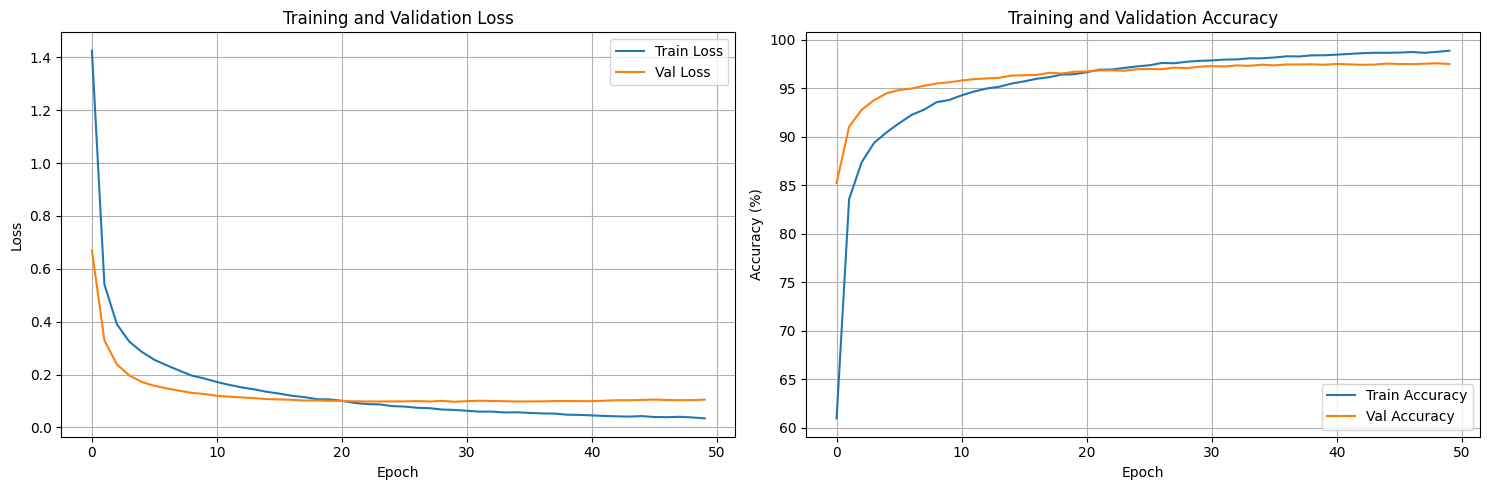

Training completed!


In [8]:
def main():
    """
    Main training pipeline for FP4 EfficientNet
    """
    print("Starting FP4 EfficientNet Quantization-Aware Training")
    
    # Prepare data
    print("Preparing data...")
    train_loader, val_loader = prepare_data(batch_size=32)
    
    # Create quantized model
    print("Creating quantized EfficientNet model...")
    model = QuantizedEfficientNet(model_name='efficientnet-b0', num_classes=10)
    
    # Setup trainer
    trainer = FP4QATTrainer(model, train_loader, val_loader, device)
    
    # Train the model
    print("Starting training...")
    history = trainer.train(epochs=50)
    
    # Plot results
    plot_training_history(history)
    
    print("Training completed!")
    return model, history

def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_accs'], label='Train Accuracy')
    ax2.plot(history['val_accs'], label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the complete pipeline
if __name__ == "__main__":
    model, history = main()


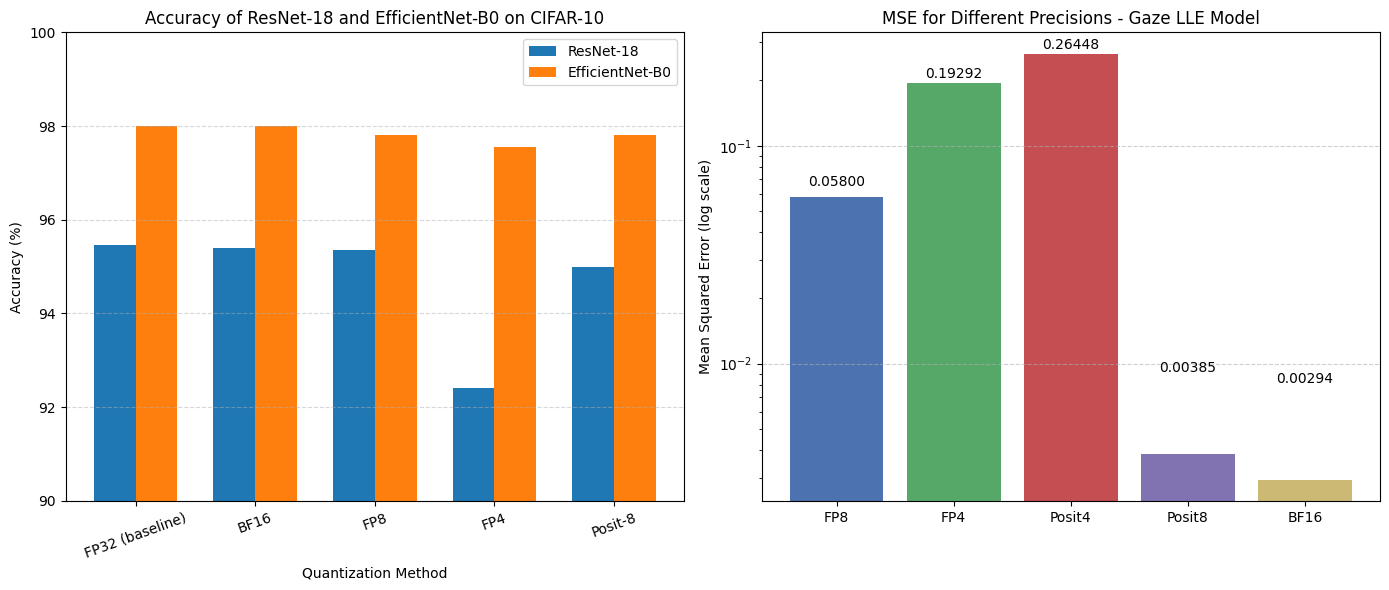

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ==== First plot data ====
methods = ["FP32 (baseline)", "BF16", "FP8", "FP4", "Posit-8"]
resnet18_acc = [95.47, 95.4, 95.35, 92.41, 95.0]
efficientnet_b0_acc = [98.0, 98.0, 97.8, 97.56, 97.8]

x = np.arange(len(methods))
width = 0.35

# ==== Second plot data ====
precisions = ['FP8', 'FP4', 'Posit4', 'Posit8', 'BF16']
mse_values = [0.05799530, 0.19292259, 0.264476, 0.00385, 0.00294]

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- First subplot ---
axes[0].bar(x - width/2, resnet18_acc, width, label="ResNet-18")
axes[0].bar(x + width/2, efficientnet_b0_acc, width, label="EfficientNet-B0")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_xlabel("Quantization Method")
axes[0].set_title("Accuracy of ResNet-18 and EfficientNet-B0 on CIFAR-10")
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=20)
axes[0].set_ylim(90, 100)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend()

# --- Second subplot ---
bars = axes[1].bar(precisions, mse_values,
                   color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974'])
for bar, mse in zip(bars, mse_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{mse:.5f}", ha='center', va='bottom')

axes[1].set_yscale('log')
axes[1].set_ylabel('Mean Squared Error (log scale)')
axes[1].set_title('MSE for Different Precisions - Gaze LLE Model')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
